In [1]:
pip install scikit-learn -U

Note: you may need to restart the kernel to use updated packages.


In [2]:
pip install phik -q

Note: you may need to restart the kernel to use updated packages.


In [3]:
pip install missingno -q

Note: you may need to restart the kernel to use updated packages.


In [4]:
pip install matplotlib==3.4.1 -q

Note: you may need to restart the kernel to use updated packages.


# Телекоммуникации
Оператор связи «ТелеДом» хочет бороться с оттоком клиентов. Для этого его сотрудники начнут предлагать промокоды и специальные условия всем, кто планирует отказаться от услуг связи. Чтобы заранее находить таких пользователей, «ТелеДому» нужна модель, которая будет предсказывать, разорвёт ли абонент договор. Команда оператора собрала персональные данные о некоторых клиентах, информацию об их тарифах и услугах.

Задача — обучить на этих данных модель для прогноза оттока клиентов.

# Ход работы
Есть 4 датафрейма, содержащие данные о пользователях и услугах, предоставляемых им. Для начала нам необходимо их загрузить, осмотреть, предобработать. Затем необходимо их объединить по ключу, после чего снова предобработать и исследовать, добавляя новые столбцы при необходимости. Затем надо выделить целевой признак. После этого делим на две выборки: тренировочную и тестовую в соотношении 3:1. Затем строим пайплайны обработки данных - обучения моделей кроссвалидацией. Ищем по метрике ROC-AUC >= 85%. Лучшую модель проверяем на тестовой выборке. Делаем выводы.

Из этого вытекает 7 этапов:
- загрузка, предобработка и исследование датафреймов
- объединение по ключу
- загрузка, предобработка и исследование объединенного датафрейма
- получение выборок
- преобразование данных - обучение моделей (пайплайн)
- проверка лучшей модели на тестовой выборке
- вывод

In [5]:
import warnings

import pandas as pd
import missingno as msno
import matplotlib.pyplot as plt
import math
import scipy.stats as st
import pylab
import numpy as np
import seaborn as sns

from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression 

from sklearn.metrics import (
    mean_squared_error, confusion_matrix, 
    ConfusionMatrixDisplay, recall_score, precision_score, 
    f1_score, accuracy_score, 
    precision_recall_curve, 
    roc_auc_score, roc_curve
)

from sklearn.utils import shuffle

from sklearn.compose import make_column_transformer
from sklearn.ensemble import RandomForestRegressor
from catboost import CatBoostClassifier
import lightgbm as lgb

from sklearn.model_selection import (
    GridSearchCV,
    RandomizedSearchCV,
    train_test_split
)
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import (
    OneHotEncoder,
    OrdinalEncoder,
    StandardScaler
)

import phik

from phik import resources
from phik.binning import bin_data
from phik.report import plot_correlation_matrix

warnings.filterwarnings("ignore")
RANDOM_STATE = 13112023 # требование заказчика

Сразу пропишу функцию для анализа датафрейма (использовал её во многих проектах)

In [6]:
def df_description(df, hist_needed = True, display_all_columns = True):
    print(f'Описание датафрейма \'{df.name}\'')
    print('Общая информация')
    df.info()
    print('\nДубликаты')
    if df.duplicated().sum() > 0:
        print(f'В датафрейме {df.name} {df.duplicated().sum()} дубликатов')
    else:
        print(f'В датафрейме {df.name} нет дубликатов')
    print('\nПропуски')
    msno.bar(df, figsize=(5,5), fontsize=9);
    msno.matrix(df, figsize=(5,5), fontsize=9);
    plt.show()
    print('Максимальные проценты пропусков')
    miss = df.isna().sum()*100/df.shape[0]
    display(miss.sort_values(ascending = False).head())
    # если необходимо вывести на экран гистограммы распределения данных
    numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']    
    if (hist_needed == True) & (df.select_dtypes(include=numerics).shape[1] > 0):
        print('\nВиды распределений данных')
        font = {'weight' : 'bold',
        'size'   : 9}
        plt.rc('font', **font)
        df.hist(figsize=(10, 10))
        plt.show()
    # если необходимо вывести расчеты для всех столбцов
    if display_all_columns == True:
        pd.set_option('display.max_columns', None)
    
    print('\nОсновные расчеты')
    display(df.describe())
    print('\nПервые пять строчек')
    display(df.head())

## Загрузка данных
Для начала необходимо загрузить данные и провести первичный осмотр

In [7]:
# датасет с информацией о договоре
contract = pd.read_csv("/datasets/contract_new.csv")
contract.name = 'Contract information'
# датасет с информацией об интернет-услугах
internet = pd.read_csv("/datasets/internet_new.csv")
internet.name = 'Internet information'
# датасет с информацией о персональных данных клиента
personal = pd.read_csv("/datasets/personal_new.csv")
personal.name = 'Personal information'
# датасет с информацией об услугах телефонии
phone = pd.read_csv("/datasets/phone_new.csv")
phone.name = 'Phone information'

Теперь последовательно выведу информацию о каждом датафрейме (пока что общую, без углублений в предобработку и исследовательский анализ)

In [8]:
display(contract.head())
contract.info()

,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges
0,7590-VHVEG,2020-01-01,No,Month-to-month,Yes,Electronic check,29.85,31.04
1,5575-GNVDE,2017-04-01,No,One year,No,Mailed check,56.95,2071.84
2,3668-QPYBK,2019-10-01,No,Month-to-month,Yes,Mailed check,53.85,226.17
3,7795-CFOCW,2016-05-01,No,One year,No,Bank transfer (automatic),42.30,1960.6
4,9237-HQITU,2019-09-01,No,Month-to-month,Yes,Electronic check,70.70,353.5


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   BeginDate         7043 non-null   object 
 2   EndDate           7043 non-null   object 
 3   Type              7043 non-null   object 
 4   PaperlessBilling  7043 non-null   object 
 5   PaymentMethod     7043 non-null   object 
 6   MonthlyCharges    7043 non-null   float64
 7   TotalCharges      7043 non-null   object 
dtypes: float64(1), object(7)
memory usage: 440.3+ KB


В датафейме, содержащем информацию о договоре, 8 столбцов, 7043 строки.
Столбцы следующие:
- `customerID` — идентификатор абонента;
- `BeginDate` — дата начала действия договора;
- **`EndDate` — дата окончания действия договора;** 
    - уже в первых строчках видно, что есть договоры без даты окончания действия, следовательно, это клиенты, которые не перестали пользоваться услугами связи оператора
- `Type` — тип оплаты: раз в год-два или ежемесячно;
- `PaperlessBilling` — электронный расчётный лист;
- `PaymentMethod` — тип платежа;
- `MonthlyCharges` — расходы за месяц;
- `TotalCharges` — общие расходы абонента.

In [9]:
display(internet.head())
internet.info()

,customerID,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies
0,7590-VHVEG,DSL,No,Yes,No,No,No,No
1,5575-GNVDE,DSL,Yes,No,Yes,No,No,No
2,3668-QPYBK,DSL,Yes,Yes,No,No,No,No
3,7795-CFOCW,DSL,Yes,No,Yes,Yes,No,No
4,9237-HQITU,Fiber optic,No,No,No,No,No,No


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5517 entries, 0 to 5516
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   customerID        5517 non-null   object
 1   InternetService   5517 non-null   object
 2   OnlineSecurity    5517 non-null   object
 3   OnlineBackup      5517 non-null   object
 4   DeviceProtection  5517 non-null   object
 5   TechSupport       5517 non-null   object
 6   StreamingTV       5517 non-null   object
 7   StreamingMovies   5517 non-null   object
dtypes: object(8)
memory usage: 344.9+ KB


В датафейме, содержащем информацию об интернет-услугах , 8 столбцов, 5517 строк.
Столбцы следующие:
- `customerID` — идентификатор пользователя;
- `InternetService` — тип подключения;
- `OnlineSecurity` — блокировка опасных сайтов;
- `OnlineBackup` — облачное хранилище файлов для резервного копирования данных;
- `DeviceProtection` — антивирус;
- `TechSupport` — выделенная линия технической поддержки;
- `StreamingTV` — стриминговое телевидение;
- `StreamingMovies` — каталог фильмов.

In [10]:
display(personal.head())
personal.info()

,customerID,gender,SeniorCitizen,Partner,Dependents
0,7590-VHVEG,Female,0,Yes,No
1,5575-GNVDE,Male,0,No,No
2,3668-QPYBK,Male,0,No,No
3,7795-CFOCW,Male,0,No,No
4,9237-HQITU,Female,0,No,No


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   customerID     7043 non-null   object
 1   gender         7043 non-null   object
 2   SeniorCitizen  7043 non-null   int64 
 3   Partner        7043 non-null   object
 4   Dependents     7043 non-null   object
dtypes: int64(1), object(4)
memory usage: 275.2+ KB


В датафейме, содержащем информацию о персональных данных клиента , 5 столбцов, 7043 строки.
Столбцы следующие:
- `customerID` — идентификатор пользователя;
- `gender` — пол;
- `SeniorCitizen` — является ли абонент пенсионером;
- `Partner` — есть ли у абонента супруг или супруга;
- `Dependents` — есть ли у абонента дети.

In [11]:
display(phone.head())
phone.info()

,customerID,MultipleLines
0,5575-GNVDE,No
1,3668-QPYBK,No
2,9237-HQITU,No
3,9305-CDSKC,Yes
4,1452-KIOVK,Yes


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6361 entries, 0 to 6360
Data columns (total 2 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   customerID     6361 non-null   object
 1   MultipleLines  6361 non-null   object
dtypes: object(2)
memory usage: 99.5+ KB


В датафейме, содержащем информацию информация об услугах телефонии, 2 столбца, 6361 строка.
Столбцы следующие:
- `customerID` — идентификатор пользователя;
- `MultipleLines` — подключение телефона к нескольким линиям одновременно.

### Промежуточный итог 1

Были загружены все датасеты и произведен их беглый осмотр. Получены следующие результаты.

В датафейме, содержащем информацию о договоре, 8 столбцов, 7043 строки.
Столбцы следующие:
- `customerID` — идентификатор абонента;
- `BeginDate` — дата начала действия договора;
- **`EndDate` — дата окончания действия договора;** 
    - уже в первых строчках видно, что есть договоры без даты окончания действия, следовательно, это клиенты, которые не перестали пользоваться услугами связи оператора
- `Type` — тип оплаты: раз в год-два или ежемесячно;
- `PaperlessBilling` — электронный расчётный лист;
- `PaymentMethod` — тип платежа;
- `MonthlyCharges` — расходы за месяц;
- `TotalCharges` — общие расходы абонента.

В датафейме, содержащем информацию об интернет-услугах , 8 столбцов, 5517 строк.
Столбцы следующие:
- `customerID` — идентификатор пользователя;
- `InternetService` — тип подключения;
- `OnlineSecurity` — блокировка опасных сайтов;
- `OnlineBackup` — облачное хранилище файлов для резервного копирования данных;
- `DeviceProtection` — антивирус;
- `TechSupport` — выделенная линия технической поддержки;
- `StreamingTV` — стриминговое телевидение;
- `StreamingMovies` — каталог фильмов.

В датафейме, содержащем информацию о персональных данных клиента , 5 столбцов, 7043 строки.
Столбцы следующие:
- `customerID` — идентификатор пользователя;
- `gender` — пол;
- `SeniorCitizen` — является ли абонент пенсионером;
- `Partner` — есть ли у абонента супруг или супруга;
- `Dependents` — есть ли у абонента дети.

В датафейме, содержащем информацию информация об услугах телефонии, 2 столбца, 6361 строка.
Столбцы следующие:
- `customerID` — идентификатор пользователя;
- `MultipleLines` — подключение телефона к нескольким линиям одновременно.

## Исследовательский анализ и предобработка данных
Теперь необходимо осмотреть каждый датафрейм в отдельности и провести его предобработку

### Датафрейм информации о договоре

Описание датафрейма 'Contract information'
Общая информация
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   BeginDate         7043 non-null   object 
 2   EndDate           7043 non-null   object 
 3   Type              7043 non-null   object 
 4   PaperlessBilling  7043 non-null   object 
 5   PaymentMethod     7043 non-null   object 
 6   MonthlyCharges    7043 non-null   float64
 7   TotalCharges      7043 non-null   object 
dtypes: float64(1), object(7)
memory usage: 440.3+ KB

Дубликаты
В датафрейме Contract information нет дубликатов

Пропуски


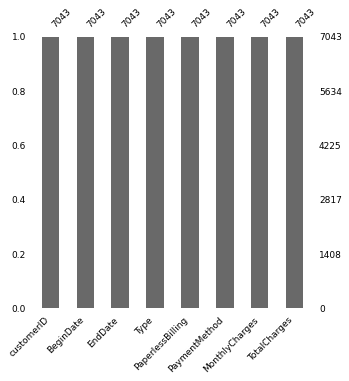

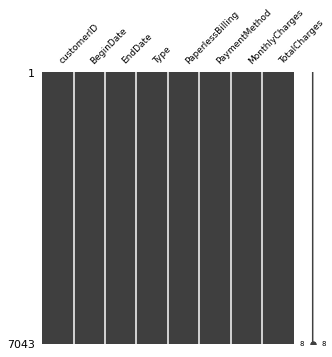

Максимальные проценты пропусков


customerID          0.0
BeginDate           0.0
EndDate             0.0
Type                0.0
PaperlessBilling    0.0
dtype: float64


Виды распределений данных


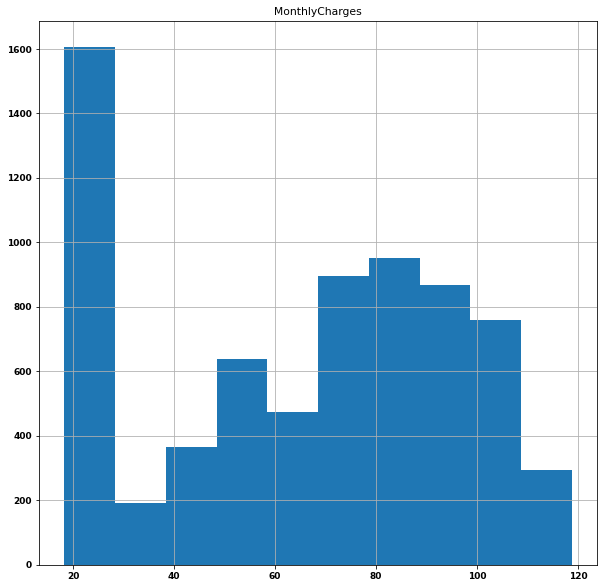


Основные расчеты


,MonthlyCharges
count,7043.000000
mean,64.761692
std,30.090047
min,18.250000
25%,35.500000
50%,70.350000
75%,89.850000
max,118.750000



Первые пять строчек


,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges
0,7590-VHVEG,2020-01-01,No,Month-to-month,Yes,Electronic check,29.85,31.04
1,5575-GNVDE,2017-04-01,No,One year,No,Mailed check,56.95,2071.84
2,3668-QPYBK,2019-10-01,No,Month-to-month,Yes,Mailed check,53.85,226.17
3,7795-CFOCW,2016-05-01,No,One year,No,Bank transfer (automatic),42.30,1960.6
4,9237-HQITU,2019-09-01,No,Month-to-month,Yes,Electronic check,70.70,353.5


In [12]:
df_description(contract)

Для начала отмечу, что дубликатов в данных нет, пропусков тоже. Налицо проблема типов данных, необходимо её исправить.

Видно, что все столбцы, кроме `MonthlyCharges` - типа `object`, хотя `BeginDate` и `TotalCharges` точно относятся не к этому типу.

In [13]:
# прежде, чем поменять, проверю, точно ли в `BeginDate` 
# все данные можно отнести к формату `DateTime`

contract.BeginDate.unique()

array(['2020-01-01', '2017-04-01', '2019-10-01', '2016-05-01',
       '2019-09-01', '2019-03-01', '2018-04-01', '2019-04-01',
       '2017-07-01', '2014-12-01', '2019-01-01', '2018-10-01',
       '2015-04-01', '2015-09-01', '2018-01-01', '2014-05-01',
       '2015-10-01', '2014-03-01', '2018-05-01', '2019-11-01',
       '2019-02-01', '2016-01-01', '2017-08-01', '2015-12-01',
       '2014-02-01', '2018-06-01', '2019-12-01', '2017-11-01',
       '2019-06-01', '2016-04-01', '2017-02-01', '2018-12-01',
       '2014-04-01', '2018-09-01', '2014-11-01', '2016-07-01',
       '2015-02-01', '2018-07-01', '2014-08-01', '2016-03-01',
       '2018-08-01', '2014-10-01', '2015-06-01', '2016-08-01',
       '2019-05-01', '2017-03-01', '2016-02-01', '2017-09-01',
       '2014-09-01', '2017-12-01', '2016-12-01', '2017-06-01',
       '2015-05-01', '2016-10-01', '2016-09-01', '2019-08-01',
       '2019-07-01', '2017-05-01', '2017-10-01', '2014-07-01',
       '2018-03-01', '2015-01-01', '2018-11-01', '2015-

In [14]:
# всё хорошо, можно привести к типу `DateTime`

contract.BeginDate = pd.to_datetime(contract.BeginDate, 
                                    format='%Y-%m-%d')
contract.info() # проверю, правильно ли перевелось

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   customerID        7043 non-null   object        
 1   BeginDate         7043 non-null   datetime64[ns]
 2   EndDate           7043 non-null   object        
 3   Type              7043 non-null   object        
 4   PaperlessBilling  7043 non-null   object        
 5   PaymentMethod     7043 non-null   object        
 6   MonthlyCharges    7043 non-null   float64       
 7   TotalCharges      7043 non-null   object        
dtypes: datetime64[ns](1), float64(1), object(6)
memory usage: 440.3+ KB


In [15]:
# теперь `TotalCharges` надо привести к вещественному типу

contract.TotalCharges = pd.to_numeric(contract.TotalCharges, errors='coerce')
contract.info() # проверка качества перевода

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   customerID        7043 non-null   object        
 1   BeginDate         7043 non-null   datetime64[ns]
 2   EndDate           7043 non-null   object        
 3   Type              7043 non-null   object        
 4   PaperlessBilling  7043 non-null   object        
 5   PaymentMethod     7043 non-null   object        
 6   MonthlyCharges    7043 non-null   float64       
 7   TotalCharges      7032 non-null   float64       
dtypes: datetime64[ns](1), float64(2), object(5)
memory usage: 440.3+ KB


Ещё раз вызову функцию описания датафрейма

Описание датафрейма 'Contract information'
Общая информация
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   customerID        7043 non-null   object        
 1   BeginDate         7043 non-null   datetime64[ns]
 2   EndDate           7043 non-null   object        
 3   Type              7043 non-null   object        
 4   PaperlessBilling  7043 non-null   object        
 5   PaymentMethod     7043 non-null   object        
 6   MonthlyCharges    7043 non-null   float64       
 7   TotalCharges      7032 non-null   float64       
dtypes: datetime64[ns](1), float64(2), object(5)
memory usage: 440.3+ KB

Дубликаты
В датафрейме Contract information нет дубликатов

Пропуски


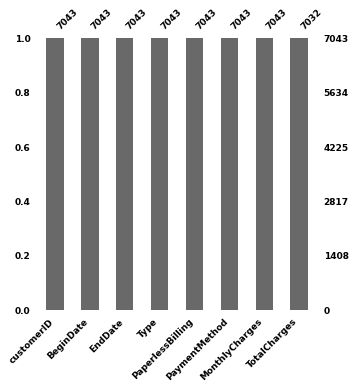

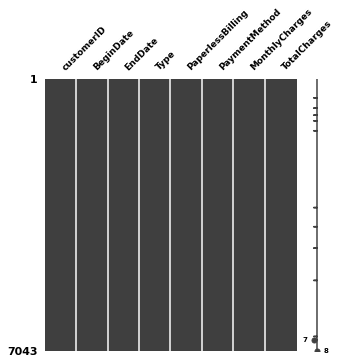

Максимальные проценты пропусков


TotalCharges    0.156183
customerID      0.000000
BeginDate       0.000000
EndDate         0.000000
Type            0.000000
dtype: float64


Виды распределений данных


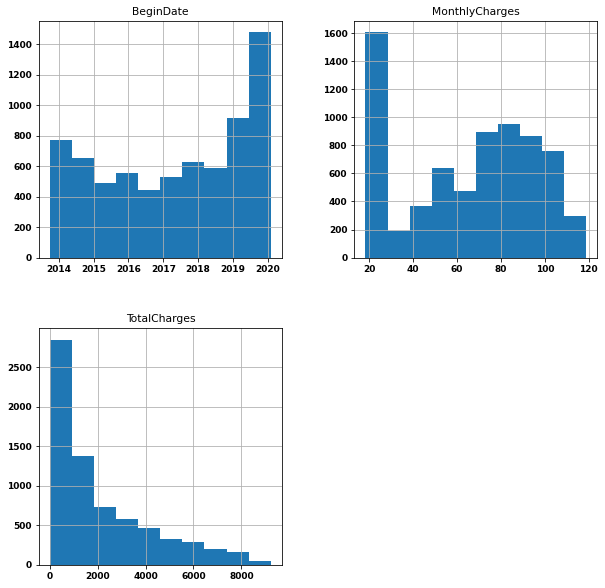


Основные расчеты


,MonthlyCharges,TotalCharges
count,7043.000000,7032.000000
mean,64.761692,2118.621822
std,30.090047,2112.736199
min,18.250000,19.050000
25%,35.500000,439.745000
50%,70.350000,1345.275000
75%,89.850000,3239.317500
max,118.750000,9221.380000



Первые пять строчек


,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges
0,7590-VHVEG,2020-01-01,No,Month-to-month,Yes,Electronic check,29.85,31.04
1,5575-GNVDE,2017-04-01,No,One year,No,Mailed check,56.95,2071.84
2,3668-QPYBK,2019-10-01,No,Month-to-month,Yes,Mailed check,53.85,226.17
3,7795-CFOCW,2016-05-01,No,One year,No,Bank transfer (automatic),42.30,1960.60
4,9237-HQITU,2019-09-01,No,Month-to-month,Yes,Electronic check,70.70,353.50


In [16]:
df_description(contract)

Видно, что это клиенты, не прекратившие пользоваться услугами, а также у них есть помесячная оплата + типы оплаты - раз в год/два. Видно, что все клиенты только зарегистрировались в системе (данные актуальны на момент `2020-02-01`), поэтому в принципе их траты можно принять равными нулю, так как, я проверил, есть клиенты с типом оплаты раз в год/два, которые зарегистрировались в январе 2020 года и их траты равны тратам одного месяца, в то время как все, кто зарегистрировался в феврале 2020 года, являются пропусками (ниже таблица)

In [17]:
contract.loc[(contract.BeginDate >= '2020-01-01') & 
((contract.Type == 'Two year') | (contract.Type == 'One year'))]

,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges
222,6469-MRVET,2020-01-01,No,One year,Yes,Electronic check,20.20,20.20
488,4472-LVYGI,2020-02-01,No,Two year,Yes,Bank transfer (automatic),52.55,NaN
753,3115-CZMZD,2020-02-01,No,Two year,No,Mailed check,20.25,NaN
936,5709-LVOEQ,2020-02-01,No,Two year,No,Mailed check,80.85,NaN
1082,4367-NUYAO,2020-02-01,No,Two year,No,Mailed check,25.75,NaN
1168,5562-BETPV,2020-01-01,No,One year,No,Mailed check,19.65,19.65
1286,8985-OOPOS,2020-01-01,No,One year,No,Credit card (automatic),74.10,74.84
1340,1371-DWPAZ,2020-02-01,No,Two year,No,Credit card (automatic),56.05,NaN
1654,2967-MXRAV,2020-01-01,No,One year,No,Mailed check,18.80,19.74
2828,8559-WNQZS,2020-01-01,No,Two year,No,Mailed check,20.45,20.45


In [18]:
contract.TotalCharges = contract.TotalCharges.fillna(0)
contract.loc[(contract.BeginDate >= '2020-01-01') & 
((contract.Type == 'Two year') | (contract.Type == 'One year'))]

,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges
222,6469-MRVET,2020-01-01,No,One year,Yes,Electronic check,20.20,20.20
488,4472-LVYGI,2020-02-01,No,Two year,Yes,Bank transfer (automatic),52.55,0.00
753,3115-CZMZD,2020-02-01,No,Two year,No,Mailed check,20.25,0.00
936,5709-LVOEQ,2020-02-01,No,Two year,No,Mailed check,80.85,0.00
1082,4367-NUYAO,2020-02-01,No,Two year,No,Mailed check,25.75,0.00
1168,5562-BETPV,2020-01-01,No,One year,No,Mailed check,19.65,19.65
1286,8985-OOPOS,2020-01-01,No,One year,No,Credit card (automatic),74.10,74.84
1340,1371-DWPAZ,2020-02-01,No,Two year,No,Credit card (automatic),56.05,0.00
1654,2967-MXRAV,2020-01-01,No,One year,No,Mailed check,18.80,19.74
2828,8559-WNQZS,2020-01-01,No,Two year,No,Mailed check,20.45,20.45


Видно, что пропуски заполнились

In [19]:
contract.TotalCharges.isna().sum() # пропусков нет 

0

Теперь посмотрю на другие столбцы этого датафрейма

In [20]:
len(contract.customerID.unique()) == contract.shape[0] # все ли ID клиентов уникальны

True

Значения поля `customerId` уникальны

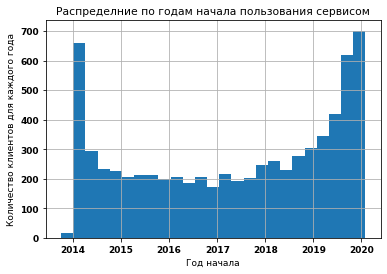

In [21]:
contract.BeginDate.hist(bins = 25)
plt.xlabel('Год начала')
plt.ylabel('Количество клиентов для каждого года')
plt.title('Распределние по годам начала пользования сервисом')
plt.show()

Видно два пика начала пользования сервисом: в 2014 и в 2020 годах

In [22]:
ratio = (contract.EndDate == 'No').sum() / contract.shape[0]
print(f'Количество клиентов, ушедших с пользование сервисом составляет {(1 - ratio):.2%} от общего количества клиентов')

Количество клиентов, ушедших с пользование сервисом составляет 15.63% от общего количества клиентов


Распределение клиентов по типам оплаты:


Month-to-month    55.019168
Two year          24.066449
One year          20.914383
Name: Type, dtype: float64

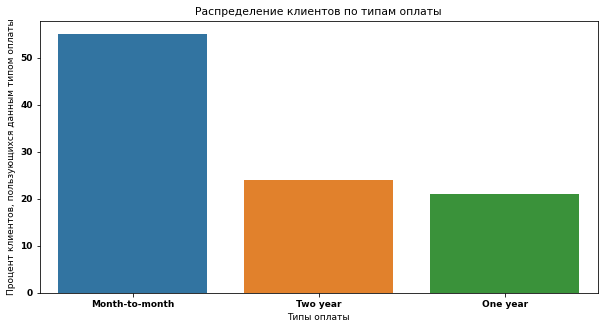

In [23]:
# уникальные значения колонки Type
print('Распределение клиентов по типам оплаты:')
display(contract.Type.value_counts(normalize=True)*100)

plt.figure(figsize = (10,5))
sns.barplot(x = contract.Type.value_counts(normalize=True).index, 
y = contract.Type.value_counts(normalize=True).values*100)
plt.xlabel('Типы оплаты')
plt.ylabel('Процент клиентов, пользующихся данным типом оплаты')
plt.title('Распределение клиентов по типам оплаты')
plt.show()

Видно, что большинство клиентов пользуются помесячной оплатой, меньше всего - оплатой раз в год, хотя их количество примерно равно количеству оплачивающих раз в два года.

Распределение клиентов по пользованию электронным расчетным листом


Yes    59.221922
No     40.778078
Name: PaperlessBilling, dtype: float64

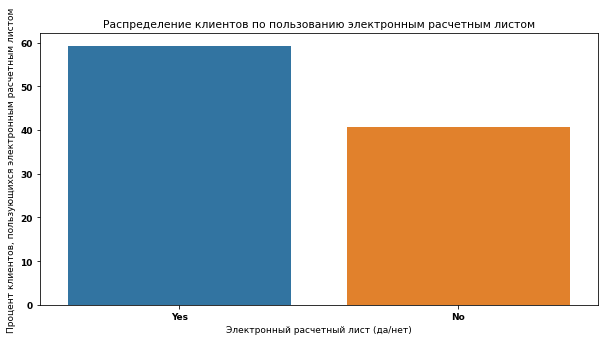

In [24]:
# электронный расчётный лист
print('Распределение клиентов по пользованию электронным расчетным листом')
display(contract.PaperlessBilling.value_counts(normalize=True)*100)

plt.figure(figsize = (10,5))
sns.barplot(x = contract.PaperlessBilling.value_counts(normalize=True).index, 
y = contract.PaperlessBilling.value_counts(normalize=True).values*100)
plt.xlabel('Электронный расчетный лист (да/нет)')
plt.ylabel('Процент клиентов, пользующихся электронным расчетным листом')
plt.title('Распределение клиентов по пользованию электронным расчетным листом')
plt.show()

Примерно 60% клиентов пользуются электронным расчетным листом, остальные - нет

Распределение клиентов по способам оплаты


Electronic check             33.579441
Mailed check                 22.887974
Bank transfer (automatic)    21.922476
Credit card (automatic)      21.610109
Name: PaymentMethod, dtype: float64

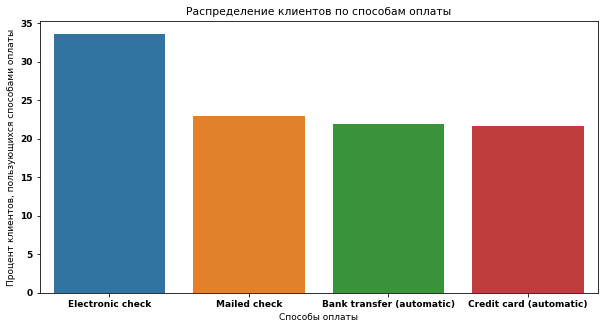

In [25]:
# способы оплаты
print('Распределение клиентов по способам оплаты')
display(contract.PaymentMethod.value_counts(normalize=True)*100)

plt.figure(figsize = (10,5))
sns.barplot(x = contract.PaymentMethod.value_counts(normalize=True).index, 
y = contract.PaymentMethod.value_counts(normalize=True).values*100)
plt.xlabel('Способы оплаты')
plt.ylabel('Процент клиентов, пользующихся способами оплаты')
plt.title('Распределение клиентов по способам оплаты')
plt.show()

Чаще всего пользуются электронным чеком, почта, банк и кредитка гораздо реже

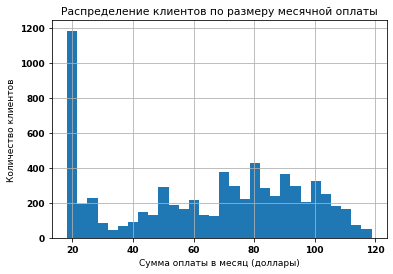

In [26]:
contract.MonthlyCharges.hist(bins = 30)
plt.xlabel('Сумма оплаты в месяц (доллары)')
plt.ylabel('Количество клиентов')
plt.title('Распределение клиентов по размеру месячной оплаты')
plt.show()

Видно пик стоимостей в районе двадцати долларов, рассмотрим подробнее

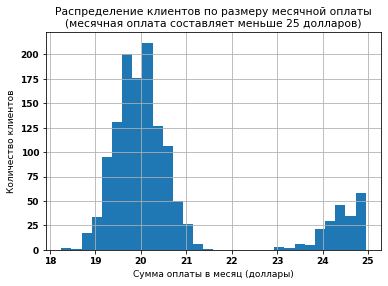

In [27]:
contract.MonthlyCharges[contract.MonthlyCharges < 25].hist(bins = 30)
plt.xlabel('Сумма оплаты в месяц (доллары)')
plt.ylabel('Количество клиентов')
plt.title('Распределение клиентов по размеру месячной оплаты\n(месячная оплата составляет меньше 25 долларов)')
plt.show()

Видно, что месячная оплата не падает ниже 18 долларов, а также есть пик в оплате от 18 до 22 долларов, затем провал (видимо, говорит об определенных тарифах) 

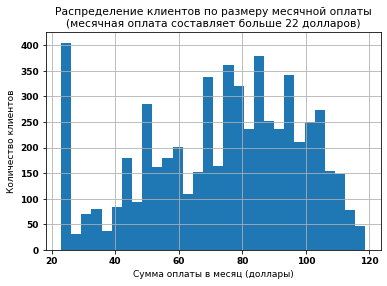

In [28]:
contract.MonthlyCharges[contract.MonthlyCharges > 22].hist(bins = 30)
plt.xlabel('Сумма оплаты в месяц (доллары)')
plt.ylabel('Количество клиентов')
plt.title('Распределение клиентов по размеру месячной оплаты\n(месячная оплата составляет больше 22 долларов)')
plt.show()

Тут видно, что есть очередной пик на цене около 25 долларов в месяц, а далее широкое распределение цен (от 30 до 120 долларов) с примерным пиком около 80 долларов

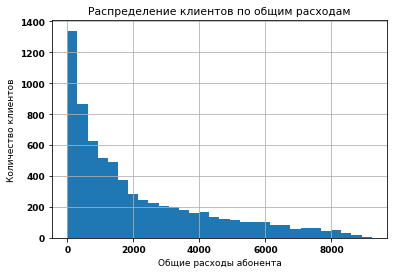

In [29]:
contract.TotalCharges.hist(bins = 30)
plt.xlabel('Общие расходы абонента')
plt.ylabel('Количество клиентов')
plt.title('Распределение клиентов по общим расходам')
plt.show()

Видно, что не очень информативно, хотя общее распределение выглядит как гиперболоид, убывающий к нулю в районе 9000 долларов. Выведу общие траты, которые меньше 500 долларов

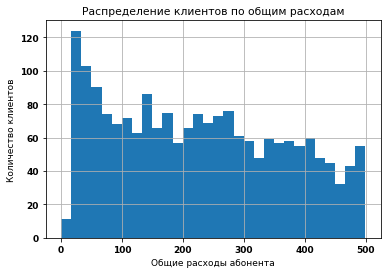

In [30]:
contract.TotalCharges[contract.TotalCharges < 500].hist(bins = 30)
plt.xlabel('Общие расходы абонента')
plt.ylabel('Количество клиентов')
plt.title('Распределение клиентов по общим расходам')
plt.show()

Видно касту людей, у которых нулевые траты (это наши заполненные пропуски, так как человеки только зарегистрировались), а также пик в районе 25 долларов, и далее почти постепенное убывание по мере увеличение общих расходов

Можно ввести новый признак с делением по уровням расходов, например, на 4 категории. Для начала найдём границы

In [31]:
ranges = pd.qcut(contract.TotalCharges, 4).sort_values().unique()

In [32]:
def get_expences_rank(df):
    df['expences_rank'] = 'unknown'
    return np.select(
    condlist = (
    df['TotalCharges'] < ranges[0].right,
    df['TotalCharges'] < ranges[1].right,
    df['TotalCharges'] < ranges[2].right, 
    df['TotalCharges'] >= ranges[3].left,),
    choicelist = ('low', 'medium','high','extra_high'),
    default = 'unknown')

contract = contract.assign(expences_rank = lambda contract_: get_expences_rank(contract))

In [33]:
contract.expences_rank.value_counts() # видно, что все прекрасно разделилось

low           1761
high          1761
extra_high    1761
medium        1760
Name: expences_rank, dtype: int64

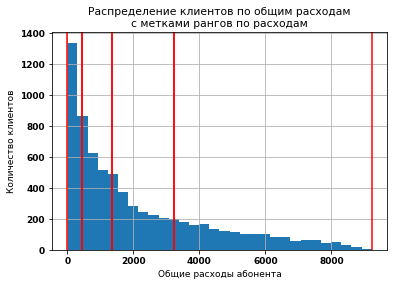

In [34]:
# нанесем деления на график
contract.TotalCharges.hist(bins = 30)
for i in range(4):
    plt.axline((ranges[i].left, 0), (ranges[i].left, 1), color = 'red')
    plt.axline((ranges[i].right, 0), (ranges[i].right, 1), color = 'red')
plt.xlabel('Общие расходы абонента')
plt.ylabel('Количество клиентов')
plt.title('Распределение клиентов по общим расходам\nс метками рангов по расходам')
plt.show()

### Датафрейм информации об интернет-услугах

Описание датафрейма 'Internet information'
Общая информация
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5517 entries, 0 to 5516
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   customerID        5517 non-null   object
 1   InternetService   5517 non-null   object
 2   OnlineSecurity    5517 non-null   object
 3   OnlineBackup      5517 non-null   object
 4   DeviceProtection  5517 non-null   object
 5   TechSupport       5517 non-null   object
 6   StreamingTV       5517 non-null   object
 7   StreamingMovies   5517 non-null   object
dtypes: object(8)
memory usage: 344.9+ KB

Дубликаты
В датафрейме Internet information нет дубликатов

Пропуски


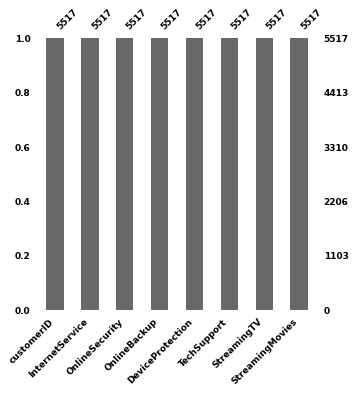

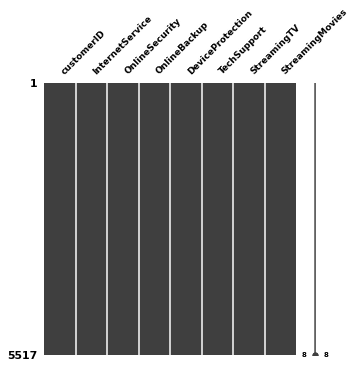

Максимальные проценты пропусков


customerID          0.0
InternetService     0.0
OnlineSecurity      0.0
OnlineBackup        0.0
DeviceProtection    0.0
dtype: float64


Основные расчеты


,customerID,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies
count,5517,5517,5517,5517,5517,5517,5517,5517
unique,5517,2,2,2,2,2,2,2
top,6728-VOIFY,Fiber optic,No,No,No,No,No,No
freq,1,3096,3498,3088,3095,3473,2810,2785



Первые пять строчек


,customerID,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies
0,7590-VHVEG,DSL,No,Yes,No,No,No,No
1,5575-GNVDE,DSL,Yes,No,Yes,No,No,No
2,3668-QPYBK,DSL,Yes,Yes,No,No,No,No
3,7795-CFOCW,DSL,Yes,No,Yes,Yes,No,No
4,9237-HQITU,Fiber optic,No,No,No,No,No,No


In [35]:
df_description(internet)

Видно, что в датафрейме с данными об интернет-услугах нет дубликатов, пропусков.
В колонке с ID пользователей нет дубликатов (count = unique).
Во всех остальных колонках по 2 значения, по сути, булевые данные, однако прям чисто буль везде, кроме `InternetService`, так как там наименования типов подключения.

В принципе, можно преобразовать типы столбцов, где Yes/No к типу boolean, но в этом, наверное, нет особой необходимости. Приведу к формату нолей и единиц


In [36]:
def to_boolean(df):
    for column in df.columns:
        if ('No' in df[column].value_counts().index):
            df[column] = df[column].apply(lambda x: 0 if x=='No' else 1)
    return df

In [37]:
internet = to_boolean(internet)

In [38]:
internet.head() # успешно преобразовали

,customerID,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies
0,7590-VHVEG,DSL,0,1,0,0,0,0
1,5575-GNVDE,DSL,1,0,1,0,0,0
2,3668-QPYBK,DSL,1,1,0,0,0,0
3,7795-CFOCW,DSL,1,0,1,1,0,0
4,9237-HQITU,Fiber optic,0,0,0,0,0,0


Визуализация распределений, пока чисто на посмотреть

In [39]:
def dict_maker(df, columns, s = ['Нет','Да']):
    dict_ = {
        s[0]: np.array([round(df[column].value_counts(normalize=True)[df[column].value_counts(normalize=True).index == 0][0]*100, 2) for column in columns]),
        s[1]: np.array([round(df[column].value_counts(normalize=True)[df[column].value_counts(normalize=True).index == 1][1]*100,2) for column in columns]),
    }
    return dict_

In [40]:
columns = internet.drop(['customerID', 'InternetService'], axis = 1).columns
zeros_ones_counts = dict_maker(internet, columns, ['Не подписан', 'Подписан'])
width = 0.6

In [41]:
# перепишу колонки так, чтобы было понятнее, что есть что
columns = ['блокировка опасных сайтов', 'облачное хранилище файлов для\nрезервного копирования данных',
'антивирус', 'выделенная линия\nтехнической поддержки', 'стриминговое телевидение', 'каталог фильмов']


In [42]:
def percentage_plotting(dict, columns, plt_title,
                        width = 0.6, ylabel = 'Процент', 
                        font_size = 12, figsize = (15,7), rotation = 0):
                        
    font = {'size'   : font_size}
    plt.rc('font', **font)

    fig, ax = plt.subplots(figsize=figsize)

    bottom = np.zeros(len(columns))

    for zeros, zeros_count in dict.items():
        p = ax.bar(columns, zeros_count, width, label=zeros, bottom=bottom)
        bottom += zeros_count

        ax.bar_label(p, label_type='center')


    ax.set_title(plt_title)
    ax.set_ylabel(ylabel)

    ax.legend()


    plt.xticks(rotation=rotation)
    plt.show()    

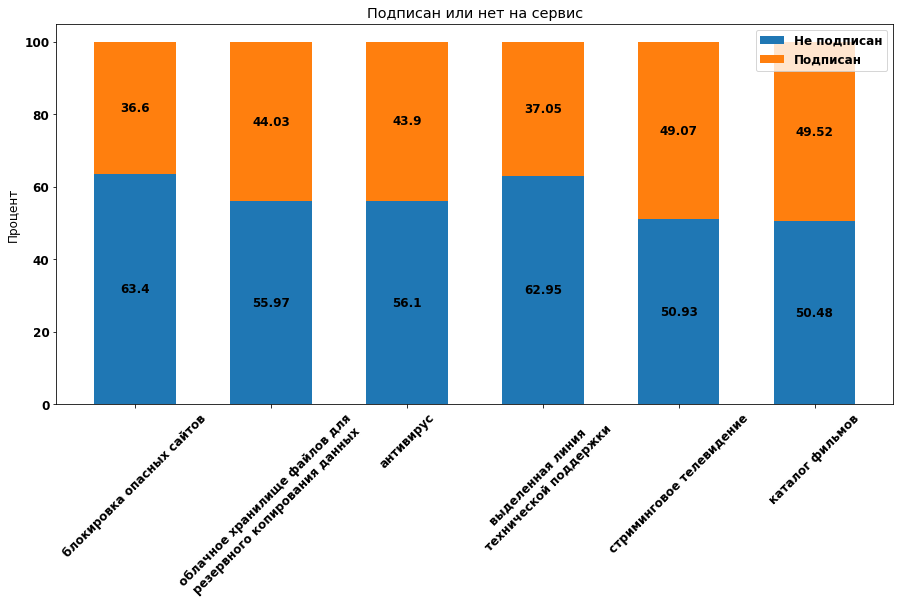

In [43]:
percentage_plotting(zeros_ones_counts, columns, 'Подписан или нет на сервис', rotation=45)

Видно, что больше всего подписок на: облачное хранилище файлов для резервного копирования данных, стриминговое телевидение и каталог фильмов

### Датасет с информацией о персональных данных клиента

Описание датафрейма 'Personal information'
Общая информация
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   customerID     7043 non-null   object
 1   gender         7043 non-null   object
 2   SeniorCitizen  7043 non-null   int64 
 3   Partner        7043 non-null   object
 4   Dependents     7043 non-null   object
dtypes: int64(1), object(4)
memory usage: 275.2+ KB

Дубликаты
В датафрейме Personal information нет дубликатов

Пропуски


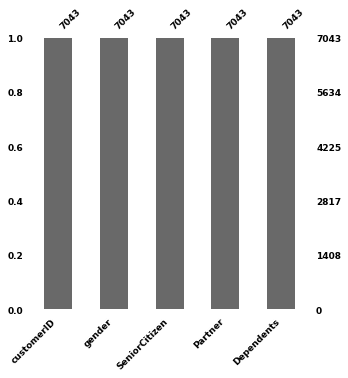

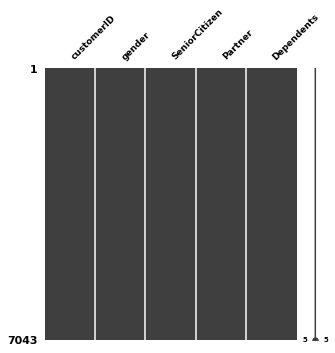

Максимальные проценты пропусков


customerID       0.0
gender           0.0
SeniorCitizen    0.0
Partner          0.0
Dependents       0.0
dtype: float64


Виды распределений данных


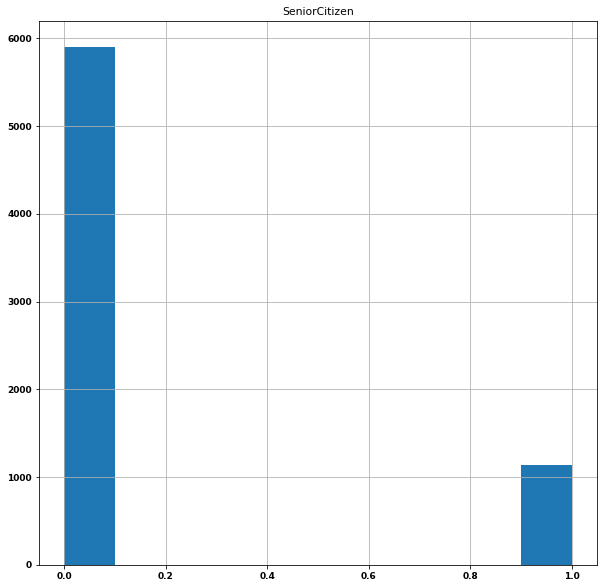


Основные расчеты


,SeniorCitizen
count,7043.000000
mean,0.162147
std,0.368612
min,0.000000
25%,0.000000
50%,0.000000
75%,0.000000
max,1.000000



Первые пять строчек


,customerID,gender,SeniorCitizen,Partner,Dependents
0,7590-VHVEG,Female,0,Yes,No
1,5575-GNVDE,Male,0,No,No
2,3668-QPYBK,Male,0,No,No
3,7795-CFOCW,Male,0,No,No
4,9237-HQITU,Female,0,No,No


In [44]:
df_description(personal)

Дубликатов нет, пропусков нет

In [45]:
# пенсионер или нет
personal.SeniorCitizen.value_counts(normalize=True)*100

0    83.785319
1    16.214681
Name: SeniorCitizen, dtype: float64

Большинство клиентов (83.79%) не являются пенсионерами

In [46]:
# наличие/отсутствие супруга/супруги
personal.Partner.value_counts(normalize=True)*100

No     51.69672
Yes    48.30328
Name: Partner, dtype: float64

Есть/нет супруг/супруга примерно 50/50 (чуть-чуть больше холостых/вдовствующих)

In [47]:
# наличие/отсутствие детей
personal.Dependents.value_counts(normalize=True)*100

No     70.041176
Yes    29.958824
Name: Dependents, dtype: float64

Примерно 30% клиентов имеют детей

In [48]:
personal = to_boolean(personal)

In [49]:
columns = personal.drop(['customerID', 'gender'], axis = 1).columns

zeros_ones_counts  = dict_maker(personal, columns)
width = 0.6

In [50]:
columns = ['Пенсионер?','Есть супруг(-а)?','Есть дети?']

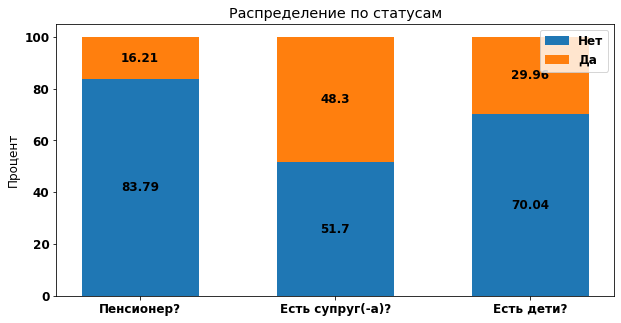

In [51]:
percentage_plotting(zeros_ones_counts, columns, 'Распределение по статусам', figsize=(10,5))

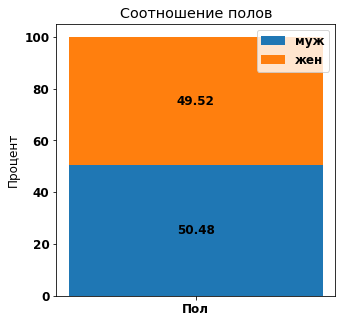

In [52]:
sex_counts = {'муж': np.array(round(personal.gender.value_counts(normalize=True)[personal.gender.value_counts(normalize=True).index == 'Male'][0]*100, 2)),
        'жен':np.array(round(personal.gender.value_counts(normalize=True)[personal.gender.value_counts(normalize=True).index == 'Female'][0]*100, 2))

}

percentage_plotting(sex_counts, ['Пол'], 'Соотношение полов', figsize=(5,5))

Полов практические одинаковое количество

Есть два столбца: наличие/отсутствие супруга(-и) и наличие/отсутствие детей.
Можно добавить столбец `is_full_family`, в котором будут значения:
- 2, если есть супруг/супруга и дети (полная семья)
- 1, если есть супруг/супруга, но нет детей (семья без детей)
- 0, все остальные случаи (неполная семья)

In [53]:
personal['is_full_family'] = 0
personal.loc[(personal.Partner == 1) & (personal.Dependents == 1), 'is_full_family'] = 2
personal.loc[(personal.Partner == 1) & (personal.Dependents == 0), 'is_full_family'] = 1

In [54]:
personal.is_full_family.value_counts(normalize=True)*100

0    51.696720
2    24.833168
1    23.470112
Name: is_full_family, dtype: float64

Видно, что больше всего клиентов из неполной семьи. Клиентов из полной семьи или семьи без детей примерно поровну между собой

### Датасет с информацией об услугах телефонии

Описание датафрейма 'Phone information'
Общая информация
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6361 entries, 0 to 6360
Data columns (total 2 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   customerID     6361 non-null   object
 1   MultipleLines  6361 non-null   object
dtypes: object(2)
memory usage: 99.5+ KB

Дубликаты
В датафрейме Phone information нет дубликатов

Пропуски


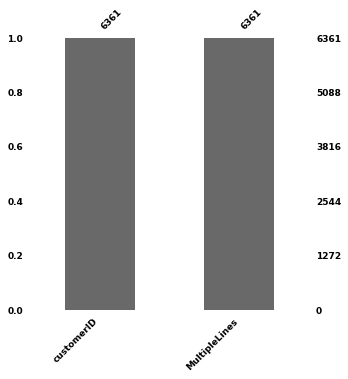

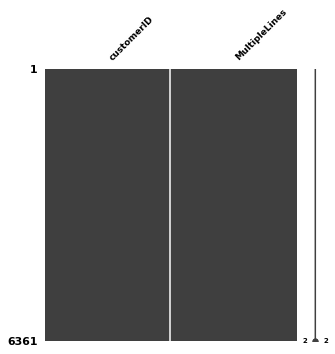

Максимальные проценты пропусков


customerID       0.0
MultipleLines    0.0
dtype: float64


Основные расчеты


,customerID,MultipleLines
count,6361,6361
unique,6361,2
top,2039-JONDJ,No
freq,1,3390



Первые пять строчек


,customerID,MultipleLines
0,5575-GNVDE,No
1,3668-QPYBK,No
2,9237-HQITU,No
3,9305-CDSKC,Yes
4,1452-KIOVK,Yes


In [55]:
df_description(phone)

Пропусков нет, дубликатов тоже

In [56]:
# подключение телефона к нескольким линиям одновременно

phone.MultipleLines.value_counts(normalize=True)*100

No     53.293507
Yes    46.706493
Name: MultipleLines, dtype: float64

Примерно 53% пользователей подключены к услуге по подключению телефона к нескольким линиям одновременно, 47% не подключены

In [57]:
# опять же, заменим Yes/No на 1/0
phone = to_boolean(phone)
phone.head() # успешно заменил

,customerID,MultipleLines
0,5575-GNVDE,0
1,3668-QPYBK,0
2,9237-HQITU,0
3,9305-CDSKC,1
4,1452-KIOVK,1


### Промежуточный итог 2
Был проведен исследовательский анализ и предобработка исходных датасетов (до объединения) с выводом соответсвующих результатов и графиков.

#### Датафрейм информации о договоре
Для начала отмечу, что дубликатов в данных нет, пропусков тоже. Налицо проблема типов данных, необходимо её исправить.

Видно, что все столбцы, кроме `MonthlyCharges` - типа `object`, хотя `BeginDate` и `TotalCharges` точно относятся не к этому типу.

Заменил типы столбцов: `MonthlyCharges` - на DateTime, а `TotalCharges` - к типу float.

После этого появились пропуски. 
Видно, что это клиенты, не прекратившие пользоваться услугами, а также у них есть помесячная оплата + типы оплаты - раз в год/два. Видно, что все клиенты только зарегистрировались в системе (данные актуальны на момент `2020-02-01`), поэтому в принципе их траты можно принять равными нулю, так как, я проверил, есть клиенты с типом оплаты раз в год/два, которые зарегистрировались в январе 2020 года и их траты равны тратам одного месяца, в то время как все, кто зарегистрировался в феврале 2020 года, являются пропусками.

Распределение по годам начала использования сервиса: видно два пика начала пользования сервисом: в 2014 и в 2020 годах.

Большинство клиентов пользуются помесячной оплатой, меньше всего - оплатой раз в год, хотя их количество примерно равно количеству оплачивающих раз в два года.

Примерно 60% клиентов пользуются электронным расчетным листом, остальные - нет

Помесячная оплата имеет где-то три пика, два острых, один сглаженный.

На распределении общих трат видно касту людей, у которых нулевые траты (это наши заполненные пропуски, так как человеки только зарегистрировались), а также пик в районе 25 долларов, и далее почти постепенное убывание по мере увеличение общих расходов до 9000. 

Был введен новый признак с делением по уровням расходов на 4 категории.

#### Датафрейм информации об интернет-услугах

Видно, что в датафрейме с данными об интернет-услугах нет дубликатов, пропусков.
В колонке с ID пользователей нет дубликатов (count = unique).
Во всех остальных колонках по 2 значения, по сути, булевые данные, однако прям чисто буль везде, кроме `InternetService`, так как там наименования типов подключения.

В принципе, можно преобразовать типы столбцов, где Yes/No к типу boolean, но в этом, наверное, нет особой необходимости. Приведу к формату нолей и единиц

Больше всего подписок на: облачное хранилище файлов для резервного копирования данных, стриминговое телевидение и каталог фильмов.

#### Датасет с информацией о персональных данных клиента

Дубликатов нет, пропусков нет.
Большинство клиентов (83.79%) не являются пенсионерами.
Есть/нет супруг/супруга примерно 50/50 (чуть-чуть больше холостых/вдовствующих).
Примерно 30% клиентов имеют детей.
Полов практические одинаковое количество.

Есть два столбца: наличие/отсутствие супруга(-и) и наличие/отсутствие детей.
Можно добавить столбец `is_full_family`, в котором будут значения:
- 2, если есть супруг/супруга и дети (полная семья)
- 1, если есть супруг/супруга, но нет детей (семья без детей)
- 0, все остальные случаи (неполная семья)

Видно, что больше всего клиентов из неполной семьи. Клиентов из полной семьи или семьи без детей примерно поровну между собой.

#### Датасет с информацией об услугах телефонии

Пропусков нет, дубликатов тоже
Примерно 53% пользователей подключены к услуге по подключению телефона к нескольким линиям одновременно, 47% не подключены

## Объединение данных
Ключ - customerID

In [58]:
data = personal.merge(contract, on='customerID', how='left').\
        merge(phone, on='customerID', how='left').\
        merge(internet, on='customerID', how='left')

In [59]:
display(data.head()), 
data.shape

,customerID,gender,SeniorCitizen,Partner,Dependents,is_full_family,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,expences_rank,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies
0,7590-VHVEG,Female,0,1,0,1,2020-01-01,No,Month-to-month,Yes,Electronic check,29.85,31.04,low,NaN,DSL,0.0,1.0,0.0,0.0,0.0,0.0
1,5575-GNVDE,Male,0,0,0,0,2017-04-01,No,One year,No,Mailed check,56.95,2071.84,high,0.0,DSL,1.0,0.0,1.0,0.0,0.0,0.0
2,3668-QPYBK,Male,0,0,0,0,2019-10-01,No,Month-to-month,Yes,Mailed check,53.85,226.17,low,0.0,DSL,1.0,1.0,0.0,0.0,0.0,0.0
3,7795-CFOCW,Male,0,0,0,0,2016-05-01,No,One year,No,Bank transfer (automatic),42.30,1960.60,high,NaN,DSL,1.0,0.0,1.0,1.0,0.0,0.0
4,9237-HQITU,Female,0,0,0,0,2019-09-01,No,Month-to-month,Yes,Electronic check,70.70,353.50,low,0.0,Fiber optic,0.0,0.0,0.0,0.0,0.0,0.0


(7043, 22)

In [60]:
num_of_rows = (max(personal.shape[0], phone.shape[0], internet.shape[0], contract.shape[0]) == data.shape[0])
num_of_cols = ((personal.shape[1]+ phone.shape[1] + internet.shape[1] + contract.shape[1] - 3) == data.shape[1])

In [61]:
if num_of_cols & num_of_rows:
    print('Данные объединились без потерь!')
else:
    print('Перепроверьте условия объединения, произошла потеря данных!')

Данные объединились без потерь!


### Промежуточный итог 3
Было произведено объединение всех фреймов данных, проверена полноценность этого объединения. Ключом служил customerID.

## Исследовательский анализ и предобработка данных объединённого датафрейма

Необходимо выполнить исследовательский анализ объединённого датафрейма, визуализировать распределения признаков и при необходимости выполнить предобработку, а также провести корреляционный анализ. 

Сначала создам целевую переменную на основании столбца объединенного датафрейма 

In [62]:
# целевая переменная о том, разорвет ли клиент договор
data['is_out'] = 1 # 1 - разорвет договор, 0 - нет

data.loc[data.EndDate == 'No', 'is_out'] = 0

In [63]:
data.is_out.value_counts(normalize=True)*100

0    84.367457
1    15.632543
Name: is_out, dtype: float64

Получается, что в районе 15.63% клиентов разрывают договор, 85.37% - нет

Добавим ещё один признак на основе дат - длительность клиентуры (No в EndDate заменим на крайнюю дату для наших данных - на `2020-02-01`)

In [64]:
latest_date = pd.to_datetime('2020-02-01')
(data.EndDate == 'No').sum()

5942

In [65]:
data.EndDate = data.EndDate.replace('No', latest_date)
(data.EndDate == latest_date).sum()

5942

In [66]:
data.EndDate = pd.to_datetime(data.EndDate)

In [67]:
data['days'] = data.EndDate - data.BeginDate
data['days'] = data['days'].dt.days

Сразу избавимся от столбцов с датами, после чего приступим к анализу

In [68]:
data = data.drop(['BeginDate', 'EndDate'], axis = 1)

На основе дней пользования сервисом построим синусоиды и косинусоиды этого признака (так может, возможно, лучше обучаться)

In [69]:
data.head()
data.name = 'merged_data'

Описание датафрейма 'merged_data'
Общая информация
<class 'pandas.core.frame.DataFrame'>
Int64Index: 7043 entries, 0 to 7042
Data columns (total 22 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   gender            7043 non-null   object 
 2   SeniorCitizen     7043 non-null   int64  
 3   Partner           7043 non-null   int64  
 4   Dependents        7043 non-null   int64  
 5   is_full_family    7043 non-null   int64  
 6   Type              7043 non-null   object 
 7   PaperlessBilling  7043 non-null   object 
 8   PaymentMethod     7043 non-null   object 
 9   MonthlyCharges    7043 non-null   float64
 10  TotalCharges      7043 non-null   float64
 11  expences_rank     7043 non-null   object 
 12  MultipleLines     6361 non-null   float64
 13  InternetService   5517 non-null   object 
 14  OnlineSecurity    5517 non-null   float64
 15  OnlineBackup      5517 non-null   floa

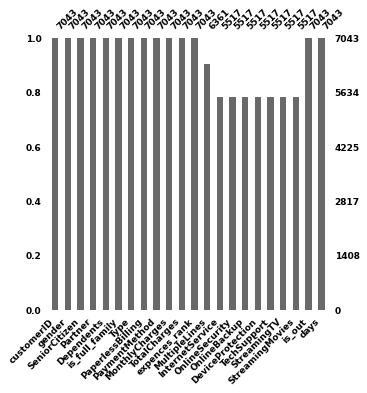

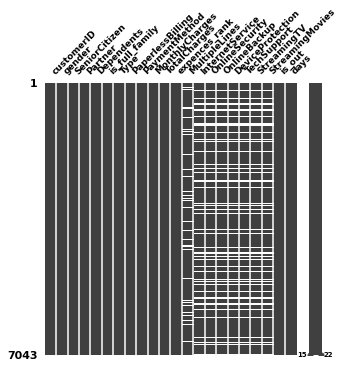

Максимальные проценты пропусков


StreamingMovies     21.666903
StreamingTV         21.666903
TechSupport         21.666903
DeviceProtection    21.666903
OnlineBackup        21.666903
dtype: float64


Виды распределений данных


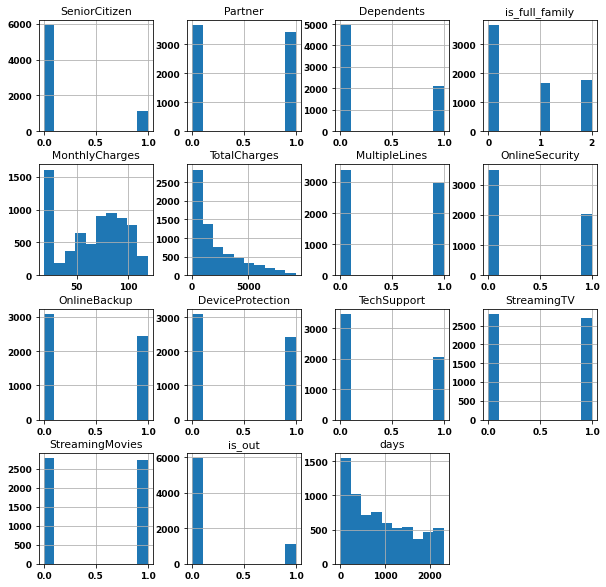


Основные расчеты


,SeniorCitizen,Partner,Dependents,is_full_family,MonthlyCharges,TotalCharges,MultipleLines,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,is_out,days
count,7043.000000,7043.000000,7043.000000,7043.000000,7043.000000,7043.000000,6361.000000,5517.000000,5517.000000,5517.000000,5517.000000,5517.000000,5517.000000,7043.000000,7043.000000
mean,0.162147,0.483033,0.299588,0.731364,64.761692,2115.312885,0.467065,0.365960,0.440276,0.439007,0.370491,0.490665,0.495197,0.156325,898.555729
std,0.368612,0.499748,0.458110,0.832606,30.090047,2112.742814,0.498953,0.481742,0.496465,0.496311,0.482980,0.499958,0.500022,0.363189,683.130510
min,0.000000,0.000000,0.000000,0.000000,18.250000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,35.500000,436.750000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,276.000000
50%,0.000000,0.000000,0.000000,0.000000,70.350000,1343.350000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,761.000000
75%,0.000000,1.000000,1.000000,1.000000,89.850000,3236.690000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000,1461.000000
max,1.000000,1.000000,1.000000,2.000000,118.750000,9221.380000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,2314.000000



Первые пять строчек


,customerID,gender,SeniorCitizen,Partner,Dependents,is_full_family,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,expences_rank,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,is_out,days
0,7590-VHVEG,Female,0,1,0,1,Month-to-month,Yes,Electronic check,29.85,31.04,low,NaN,DSL,0.0,1.0,0.0,0.0,0.0,0.0,0,31
1,5575-GNVDE,Male,0,0,0,0,One year,No,Mailed check,56.95,2071.84,high,0.0,DSL,1.0,0.0,1.0,0.0,0.0,0.0,0,1036
2,3668-QPYBK,Male,0,0,0,0,Month-to-month,Yes,Mailed check,53.85,226.17,low,0.0,DSL,1.0,1.0,0.0,0.0,0.0,0.0,0,123
3,7795-CFOCW,Male,0,0,0,0,One year,No,Bank transfer (automatic),42.30,1960.60,high,NaN,DSL,1.0,0.0,1.0,1.0,0.0,0.0,0,1371
4,9237-HQITU,Female,0,0,0,0,Month-to-month,Yes,Electronic check,70.70,353.50,low,0.0,Fiber optic,0.0,0.0,0.0,0.0,0.0,0.0,0,153


In [70]:
df_description(data)

Дубликатов нет, но появились пропуски от того, что сливаемые датафреймы имели разный размер, заполним же пропуски

Так как в объединенном датафрейме категориальные данные закодированы как 1 и 0, кроме `InternetService`, просто использую fillna(0), так как отсутствие данные равносильно отсутствию подписки на интернет-сервисы или на подключение телефона к нескольким линиям одновременно. А пропуски в `InternetService` заполню `None`.

In [71]:
data.InternetService = data.InternetService.fillna('None')
data = data.fillna(0)

In [72]:
data.isna().sum()

customerID          0
gender              0
SeniorCitizen       0
Partner             0
Dependents          0
is_full_family      0
Type                0
PaperlessBilling    0
PaymentMethod       0
MonthlyCharges      0
TotalCharges        0
expences_rank       0
MultipleLines       0
InternetService     0
OnlineSecurity      0
OnlineBackup        0
DeviceProtection    0
TechSupport         0
StreamingTV         0
StreamingMovies     0
is_out              0
days                0
dtype: int64

In [73]:
columns_with_ones_and_zeros = []
for column in data.columns:
    if (0 in data[column].unique()) & (len(data[column].unique()) == 2):
        columns_with_ones_and_zeros.append(column)

Все пропуски заполнены, теперь можно снова посмотреть на распределения данных.
Пока посмотрю без привязки к целевой переменной. Просто на их процентное распределение.

In [74]:
not_out_target = dict_maker(data.loc[data.is_out == 0], columns_with_ones_and_zeros[:-1])
is_out_target = dict_maker(data.loc[data.is_out == 1], columns_with_ones_and_zeros[:-1])

In [75]:
yes_list = []
for i in range(len(not_out_target.get('Да'))):
    yes_list.append(not_out_target.get('Да')[i])
    yes_list.append(is_out_target.get('Да')[i])
no_list = []
for i in range(len(not_out_target.get('Нет'))):
    no_list.append(not_out_target.get('Нет')[i])
    no_list.append(is_out_target.get('Нет')[i])

In [76]:
dict_for_comparison = {
    'нет':np.array(no_list),
    'да': np.array(yes_list)
}

In [77]:
columns = []
for cols in columns_with_ones_and_zeros[:-1]:
    columns.append(f'{cols}_not_out')
    columns.append(f'{cols}_is__out')

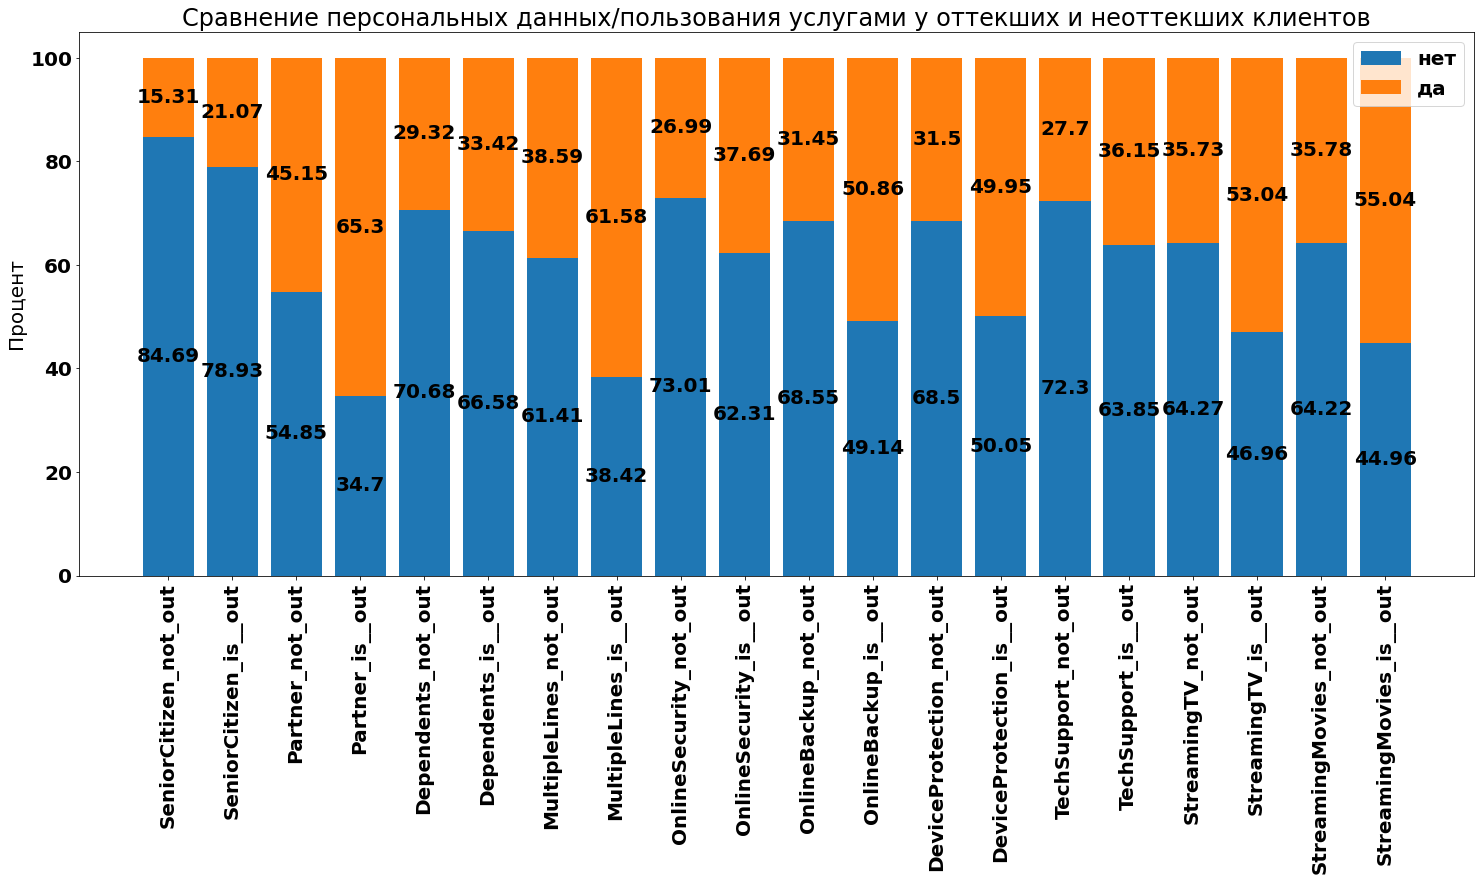

In [78]:
percentage_plotting(dict_for_comparison, 
columns, 'Сравнение персональных данных/пользования услугами у оттекших и неоттекших клиентов', figsize=(25,10),
rotation = 90, font_size = 20, width = 0.8)

- `SeniorCitizen` — является ли абонент пенсионером;
- `Partner` — есть ли у абонента супруг или супруга;
- `Dependents` — есть ли у абонента дети;
- `MultipleLines` — есть ли услуга подключения телефона к нескольким линиям одновременно;
- `OnlineSecurity` — есть ли услуга блокировки опасных сайтов;
- `OnlineBackup` — есть ли услуга облачного хранилища файлов для резервного копирования данных;
- `DeviceProtection` — есть ли услуга антивируса;
- `TechSupport` — есть ли услуга выделенной линии технической поддержки;
- `StreamingTV` — есть ли услуга стримингового телевидения;
- `StreamingMovies` — есть ли услуга каталога фильмов

Приписка `not_out` значит, что клиент не разорвал договор, а `is__out` - разорвал

Видно, что по всем признакам процент клиентов, имеющих тот или иной признак, выше среди выборки клиентов, разорвавших контракт, по сравнению с теми, кто не разорвал

Рассмотрим отток клиентов по признакам. Тут будет по отсутствию чего-либо

In [79]:
dict_for_not_users = {'is_not_out': [round(data.loc[data[column] == 0, 'is_out'].value_counts(normalize = True)[data.loc[data[column] == 0, 'is_out'].value_counts().index == 0][0]*100,2) for column in columns_with_ones_and_zeros[:-1]],
            'is_out': [round(data.loc[data[column] == 0, 'is_out'].value_counts(normalize = True)[data.loc[data[column] == 0, 'is_out'].value_counts().index == 1][1]*100,2) for column in columns_with_ones_and_zeros[:-1]]}

In [80]:
dict_for_users = {'is_not_out': [round(data.loc[data[column] == 1, 'is_out'].value_counts(normalize = True)[data.loc[data[column] == 1, 'is_out'].value_counts().index == 0][0]*100,2) for column in columns_with_ones_and_zeros[:-1]],
            'is_out': [round(data.loc[data[column] == 1, 'is_out'].value_counts(normalize = True)[data.loc[data[column] == 1, 'is_out'].value_counts().index == 1][1]*100,2) for column in columns_with_ones_and_zeros[:-1]]}

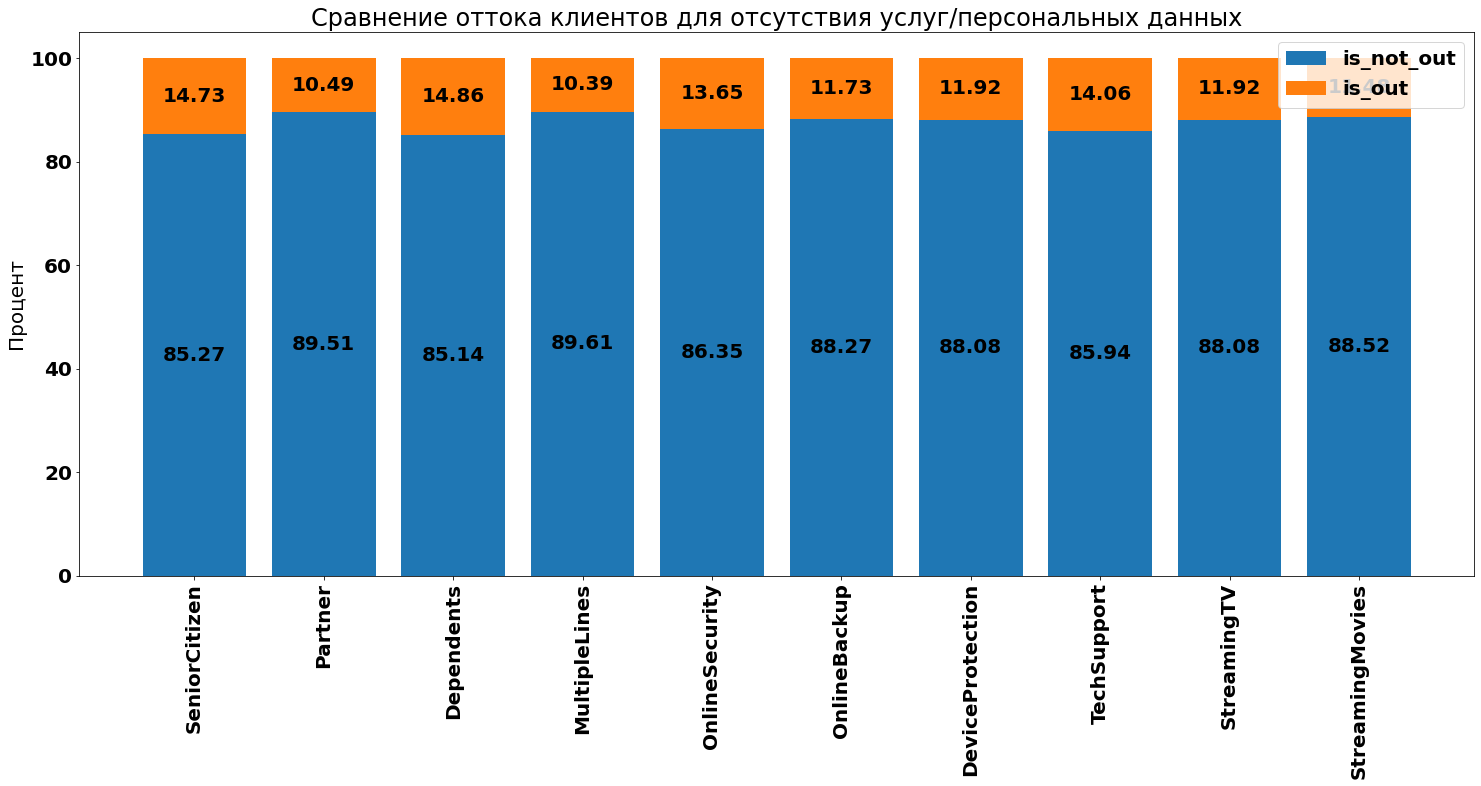

In [81]:
percentage_plotting(dict_for_not_users, 
columns_with_ones_and_zeros[:-1], 'Сравнение оттока клиентов для отсутствия услуг/персональных данных', figsize=(25,10),
rotation = 90, font_size = 20, width = 0.8)

У клиентов, у которых либо нет подписок, либо они не пенсионеры, либо не имеют супруга/супругу или детей практически нет разницы в целевой переменной

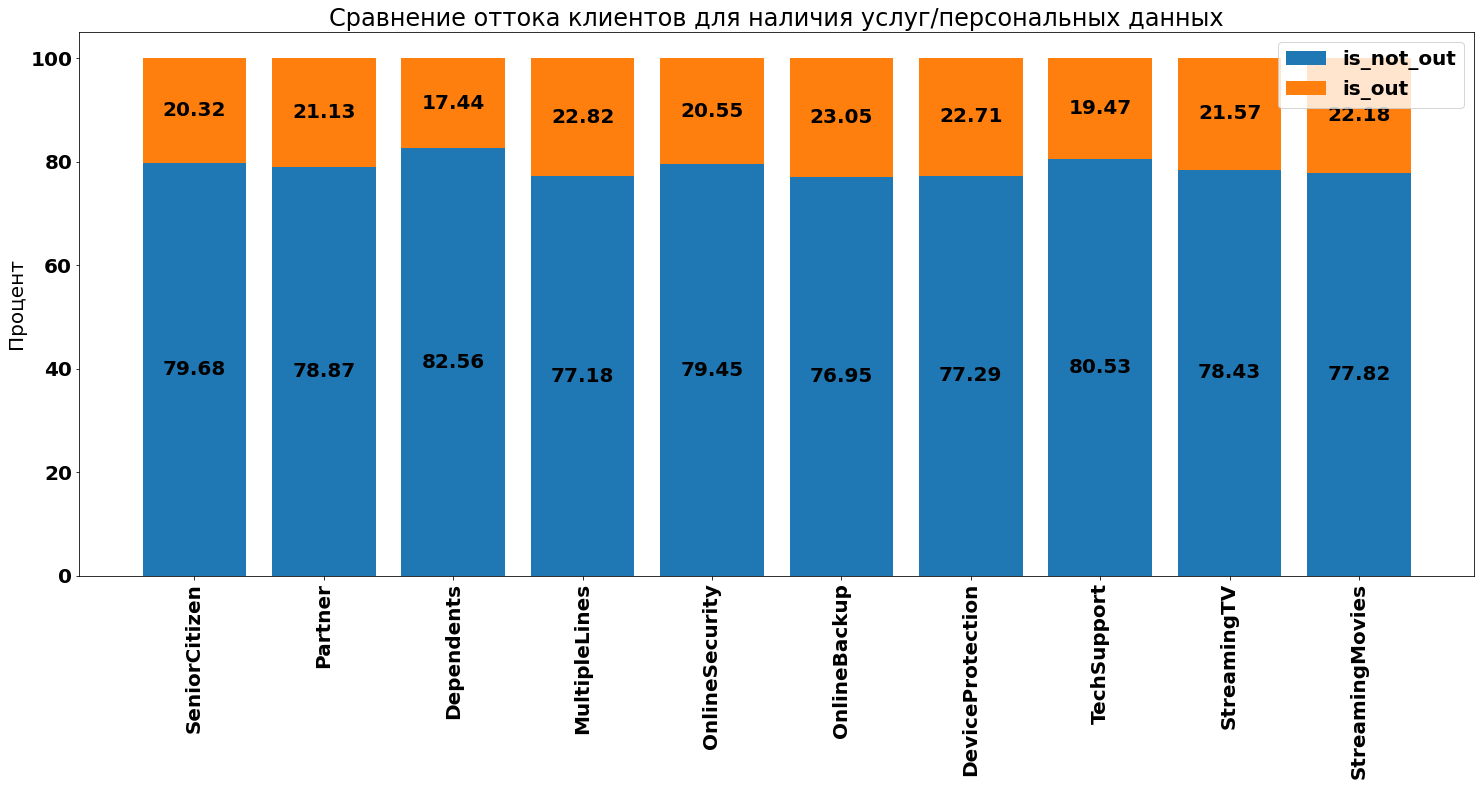

In [82]:
percentage_plotting(dict_for_users, 
columns_with_ones_and_zeros[:-1], 'Сравнение оттока клиентов для наличия услуг/персональных данных', figsize=(25,10),
rotation = 90, font_size = 20, width = 0.8)

У клиентов, у которых либо есть подписки, либо они пенсионеры, либо имеют супруга/супругу или детей практически нет разницы в целевой переменной

In [83]:
is_out_list = []
for i in range(len(dict_for_not_users.get('is_out'))):
    is_out_list.append(dict_for_users.get('is_out')[i])
    is_out_list.append(dict_for_not_users.get('is_out')[i])
is_not_out_list = []
for i in range(len(dict_for_not_users.get('is_not_out'))):
    is_not_out_list.append(dict_for_users.get('is_not_out')[i])
    is_not_out_list.append(dict_for_not_users.get('is_not_out')[i])

In [84]:
dict_for_outflow = {
    'is_not_out':np.array(is_not_out_list),
    'is_out':np.array(is_out_list)
    
}

In [85]:
yes_no_columns = []
for cols in columns_with_ones_and_zeros[:-1]:
    yes_no_columns.append(f'{cols}_yes')
    yes_no_columns.append(f'{cols}__no')

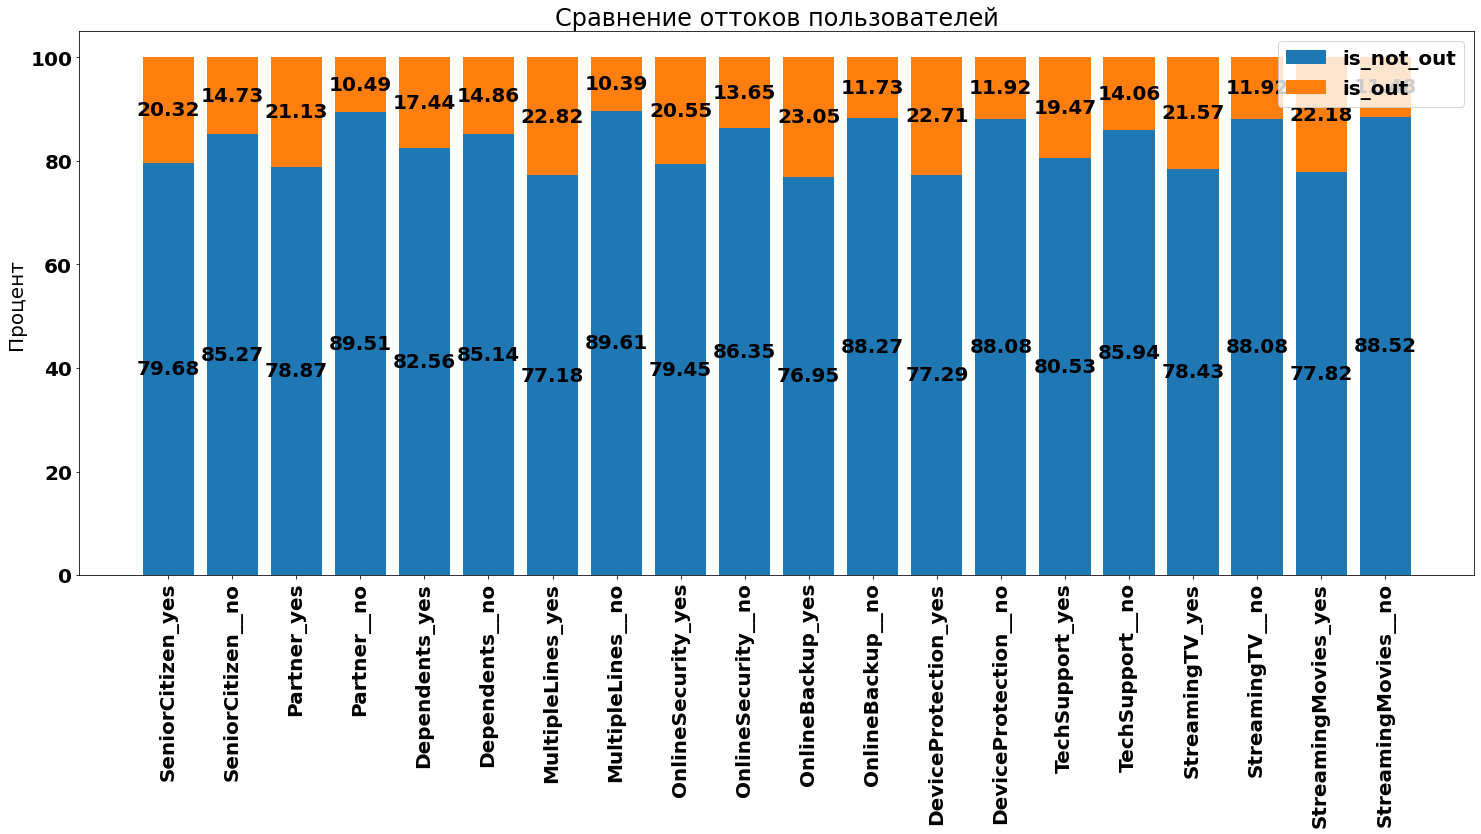

In [86]:
percentage_plotting(dict_for_outflow, 
yes_no_columns, 
'Сравнение оттоков пользователей', figsize=(25,10),
rotation = 90, font_size = 20, width = 0.8)

Опять же, видно, что пользователи услуг/пенсионеры/люди с супругом(-ой) или детьми чаще оттекают чем те, у которых нет этого.

- пенсионеры оттекают чаще, чем не пенсионеры на 6%
- люди с супругом(-ой) оттекают чаще, чем без на 11%
- люди с детьми оттекают чаще, чем без на 2.5%
- люди с услугой подключения телефона к нескольким линиям одновременно оттекают чаще на 12.5%
- люди с блокировкой опасных сайтов оттекают чаще на 7%
- люди с облачным хранилищем файлов для резервного копирования данных оттекают чаще на 11.5%
- люди с антивирусом оттекают чаще на 11%
- люди с выделенной линией технической поддержки оттекают чаще на 5.5%
- люди со стриминговым телевидением оттекают чаще на 9.5%
- люди с каталогом фильмов оттекают чаще на 11%

Необходимо избавиться от бесполезного столбца customerID, он свое дело в объединении датафрейма уже выполнил

In [87]:
data = data.drop('customerID', axis = 1)
data.columns

Index(['gender', 'SeniorCitizen', 'Partner', 'Dependents', 'is_full_family',
       'Type', 'PaperlessBilling', 'PaymentMethod', 'MonthlyCharges',
       'TotalCharges', 'expences_rank', 'MultipleLines', 'InternetService',
       'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport',
       'StreamingTV', 'StreamingMovies', 'is_out', 'days'],
      dtype='object')

In [88]:
# выделю категориальные столбцы, в которых значений больше, 
# чем два (не булевые) или они не равны 1/0

cat_columns = ['gender', 'Type','PaperlessBilling','PaymentMethod', 'expences_rank','InternetService']

In [89]:
def cat_dict_maker(df, column):
    s = list(df[column].unique())
    dict_ = {
        s[j]: round(df[column].value_counts(normalize=True)[df[column].value_counts(normalize=True).index == s[j]][0]*100, 2) for j in range(len(s))
    }
    return dict_

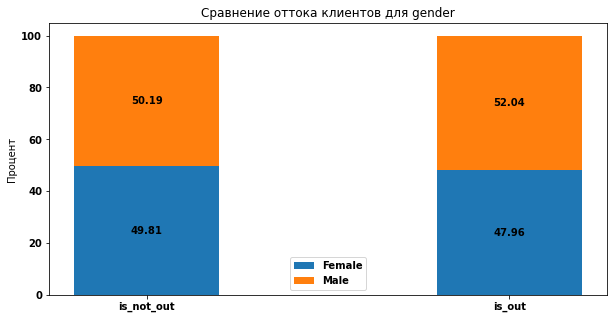

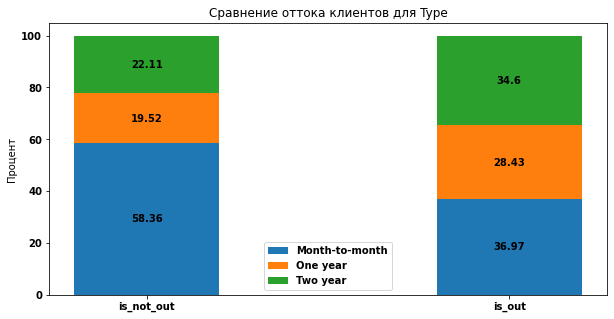

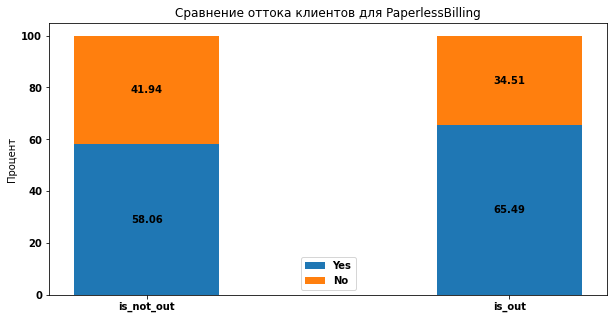

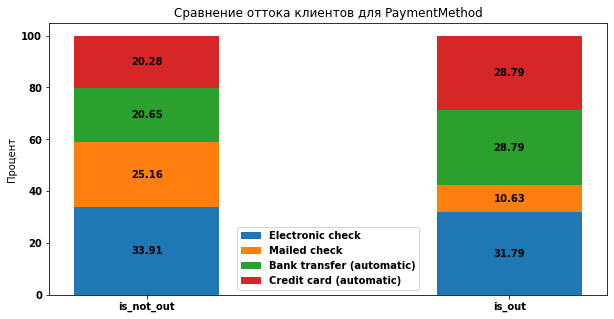

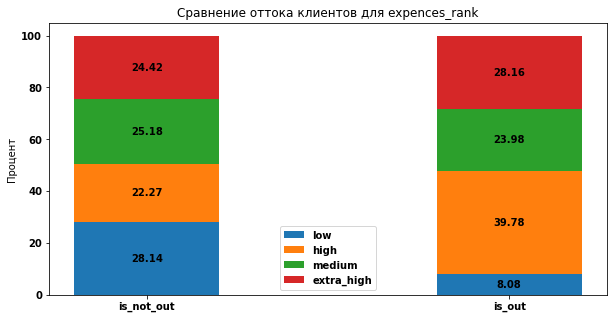

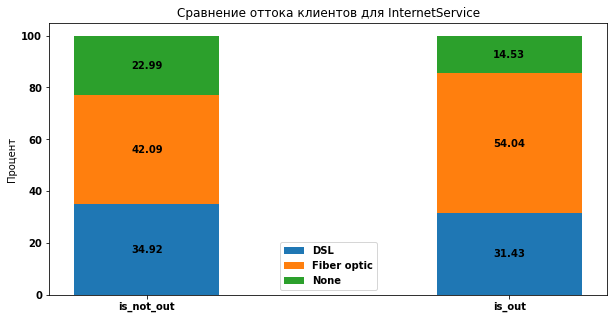

In [90]:
for col in cat_columns:
    is_not_out = cat_dict_maker(data[data.is_out == 0], col)
    is_out = cat_dict_maker(data[data.is_out == 1], col)
    cat_list = list(data[col].unique())

    dict_for_outflow = {
        cat_list[i]: [is_not_out.get(cat_list[i]), is_out.get(cat_list[i])]for i in range(len(cat_list))
    }
    percentage_plotting(dict_for_outflow, ['is_not_out', 'is_out'], 
    f'Сравнение оттока клиентов для {col}', 
    figsize=(10,5),rotation = 0, font_size = 10, width = 0.4)
    

Что видно:
- практически нет разницы в соотношении полов между дейсвтующими и оттекшими клиентами
- по способу оплаты видно, что чаще оттекают клиенты с оплатой раз в год или два, тогда как клиенты с помесячной оплатой оттекают меньше
- чуть чаще оттекают люди с электронным расчетным листом
- реже всего по типу платежа оттекают клиенты с чеком по почте, в то время как клиенты с автоматическим банковским трансфером или электронным чеком оттекают чаще 
- по уровню расходов видно, что очень мало оттекает клиентов с низкими тратами (до 500 долларов), в то время с высокими тратами (от 1500 до 3000 долларов) оттекают чаще всего, их отток выше аж почти на 20%
- клиенты с оптоволовном оттекают чаще на 12%

Попробую поменять все 0/1 на No/Yes, чтобы далее перекодировать

In [91]:
for col in data.columns:
    if (len(data[col].unique()) == 2) & (0 in data[col].unique()) & (col != 'is_out'):
        data[col] = data[col].replace([0, 1], ['No','Yes'])

In [92]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7043 entries, 0 to 7042
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   gender            7043 non-null   object 
 1   SeniorCitizen     7043 non-null   object 
 2   Partner           7043 non-null   object 
 3   Dependents        7043 non-null   object 
 4   is_full_family    7043 non-null   int64  
 5   Type              7043 non-null   object 
 6   PaperlessBilling  7043 non-null   object 
 7   PaymentMethod     7043 non-null   object 
 8   MonthlyCharges    7043 non-null   float64
 9   TotalCharges      7043 non-null   float64
 10  expences_rank     7043 non-null   object 
 11  MultipleLines     7043 non-null   object 
 12  InternetService   7043 non-null   object 
 13  OnlineSecurity    7043 non-null   object 
 14  OnlineBackup      7043 non-null   object 
 15  DeviceProtection  7043 non-null   object 
 16  TechSupport       7043 non-null   object 


### Наличие корреляции
Проверю наличие корреляции с помощью библиотеки `phik`

In [93]:
# для phik требуется обозначить столбцы с непрерывными количественными значениями
interval_cols = ['MonthlyCharges', 'TotalCharges','days', 'day_sin','day_cos']
phik_overview = data.phik_matrix(interval_cols=interval_cols)

In [94]:
phik_overview

,gender,SeniorCitizen,Partner,Dependents,is_full_family,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,expences_rank,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,is_out,days
gender,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.008175,0.000000,0.000000,0.000000,0.000000,0.018397,0.009882,0.000000,0.000000,0.000000,0.000000,0.008581,0.000000
SeniorCitizen,0.000000,1.000000,0.016992,0.324576,0.142145,0.086231,0.242133,0.292725,0.304985,0.135650,0.164182,0.221313,0.160702,0.057028,0.102065,0.090686,0.092565,0.163120,0.186141,0.086159,0.063315
Partner,0.000000,0.016992,1.000000,0.652122,1.000000,0.179736,0.013218,0.243008,0.203545,0.381958,0.448308,0.220101,0.000000,0.221673,0.219223,0.238079,0.185993,0.193258,0.182011,0.226688,0.453688
Dependents,0.000000,0.324576,0.652122,1.000000,0.615039,0.147680,0.172593,0.224903,0.184366,0.084247,0.117741,0.033103,0.108463,0.124945,0.031533,0.010416,0.096912,0.017331,0.058999,0.046871,0.198729
is_full_family,0.000000,0.142145,1.000000,0.615039,1.000000,0.532911,0.065307,0.151972,0.257598,0.338818,0.232964,0.103287,0.360834,0.085864,0.089975,0.098239,0.071688,0.087142,0.091484,0.091473,0.379312
Type,0.000000,0.086231,0.179736,0.147680,0.532911,1.000000,0.106860,0.277462,0.388444,0.470860,0.309299,0.065498,0.505187,0.152145,0.098884,0.137610,0.179999,0.066961,0.069608,0.094015,0.634155
PaperlessBilling,0.000000,0.242133,0.013218,0.172593,0.065307,0.106860,1.000000,0.370495,0.467812,0.201703,0.235981,0.252972,0.231438,0.000000,0.196443,0.160796,0.055929,0.343524,0.325551,0.083398,0.026799
PaymentMethod,0.000000,0.292725,0.243008,0.224903,0.151972,0.277462,0.370495,1.000000,0.399526,0.335666,0.501565,0.339313,0.323886,0.262911,0.282475,0.306866,0.272101,0.377209,0.378907,0.214832,0.350964
MonthlyCharges,0.008175,0.304985,0.203545,0.184366,0.257598,0.388444,0.467812,0.399526,1.000000,0.710905,0.576888,0.675883,0.919002,0.551621,0.629541,0.667481,0.576525,0.835340,0.833307,0.226280,0.387727
TotalCharges,0.000000,0.135650,0.381958,0.084247,0.338818,0.470860,0.201703,0.335666,0.710905,1.000000,0.881634,0.573191,0.490081,0.522090,0.622445,0.640977,0.550065,0.641488,0.643210,0.302890,0.848337


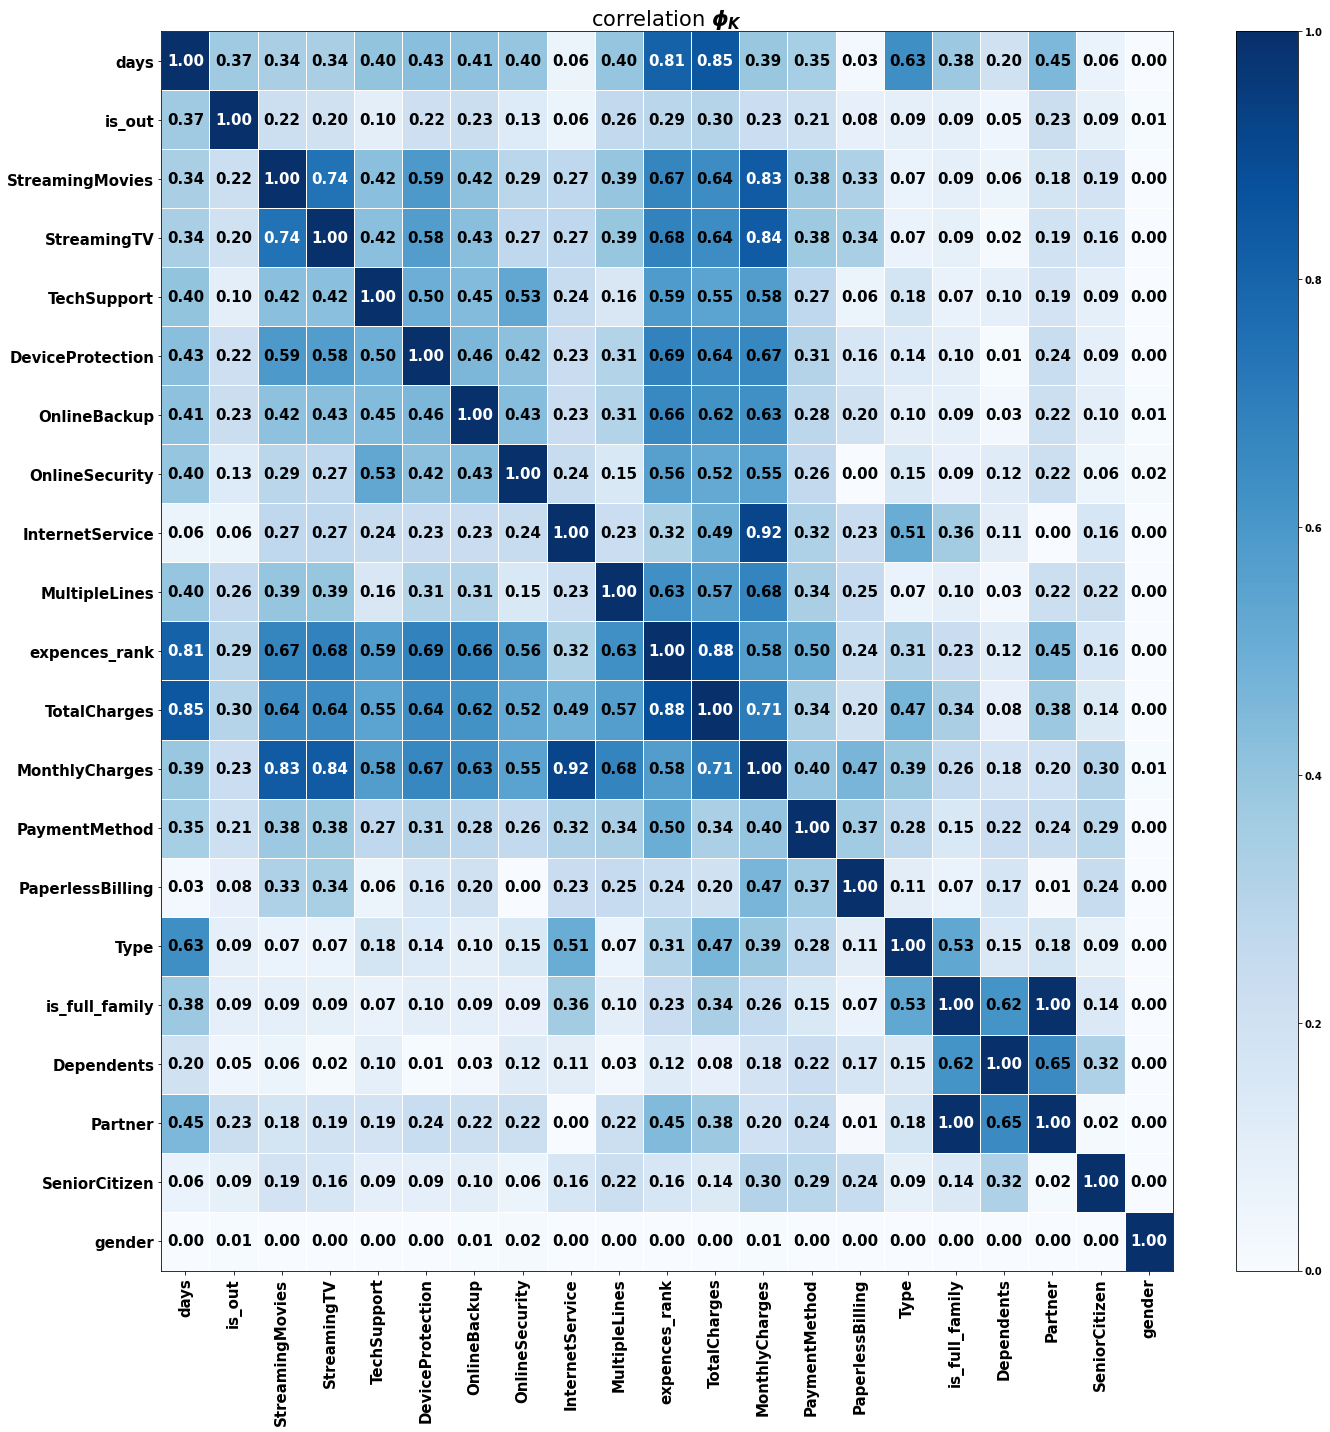

In [95]:
plot_correlation_matrix(phik_overview.values, x_labels=phik_overview.columns, y_labels=phik_overview.index, 
                        vmin=0, vmax=1, color_map='Blues', title=r'correlation $\phi_K$', fontsize_factor=1.5,
                        figsize=(20,20))
plt.tight_layout()

Была построена матрица корреляций и получены следующие данные о скоррелированности признаков (будем считать высокой корреляцие корреляцию со значением, превышающем 0,7). Выведу их отдельно, чтобы было ещё проще определить глазамиs

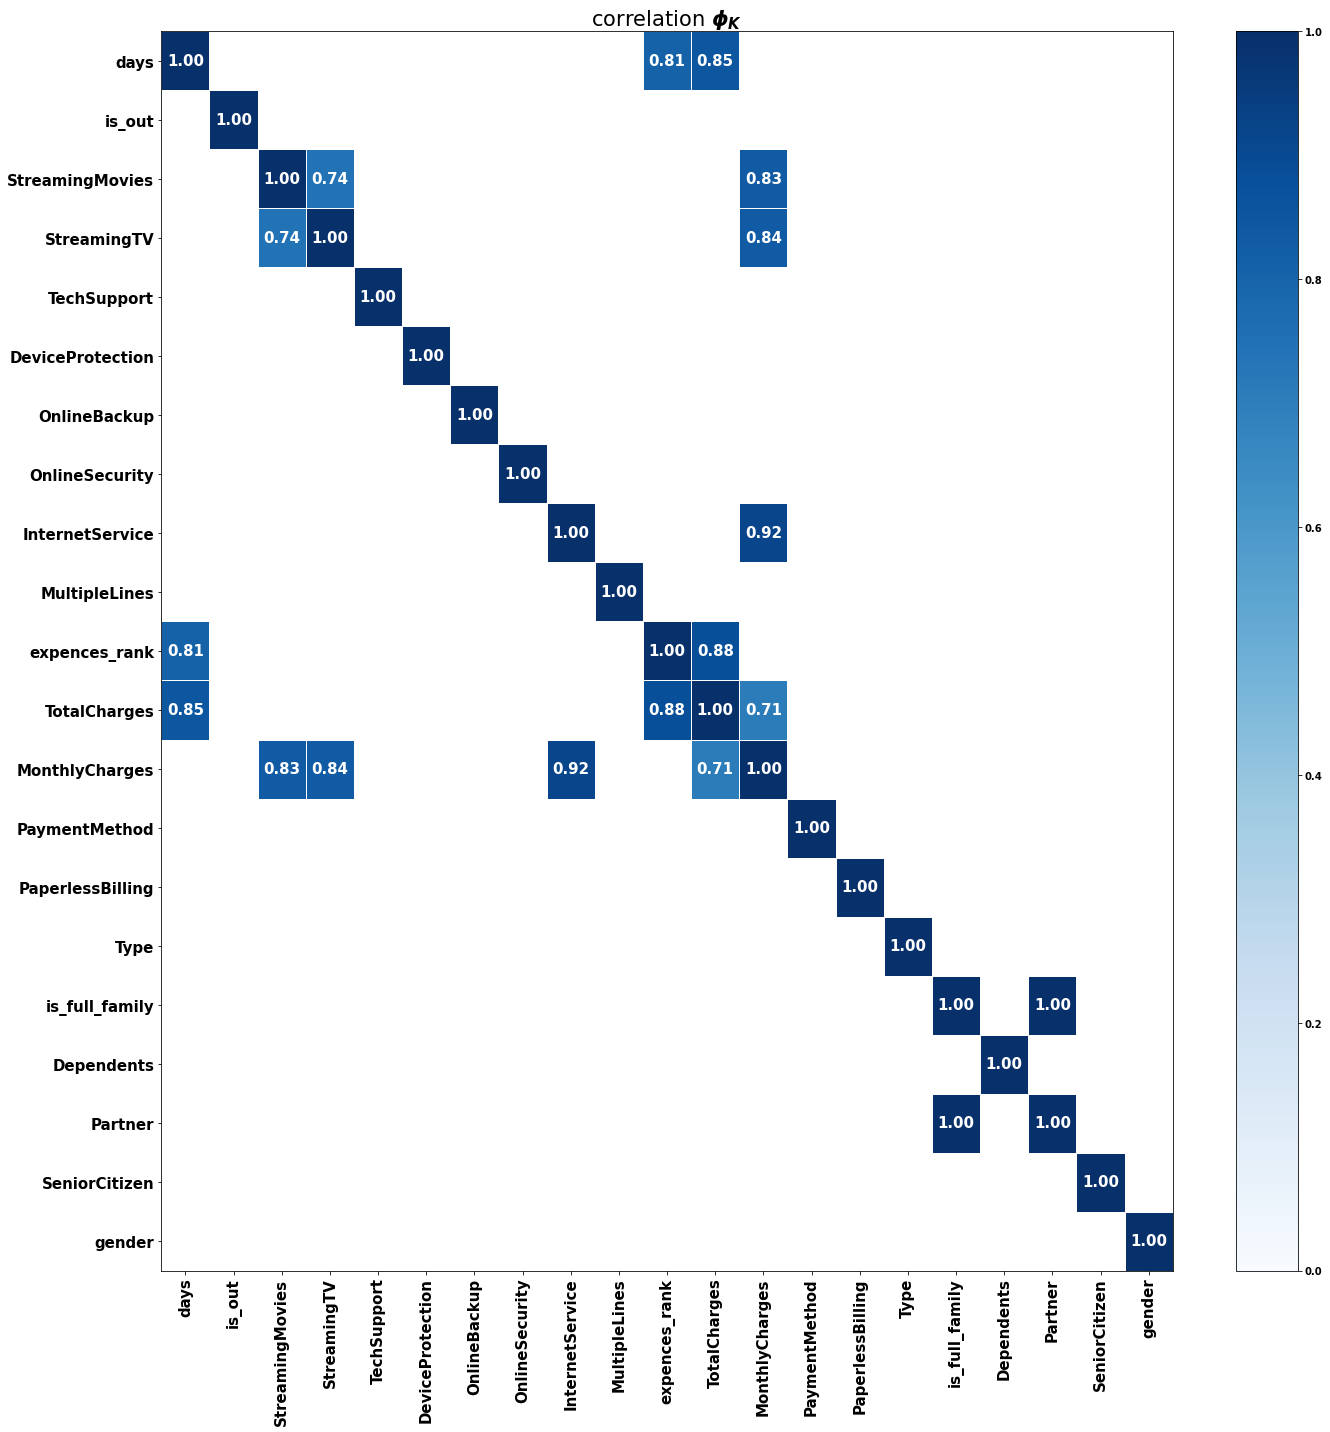

In [96]:
plot_correlation_matrix(phik_overview[phik_overview > 0.7].values, x_labels=phik_overview.columns, y_labels=phik_overview.index, 
                        vmin=0, vmax=1, color_map='Blues', title=r'correlation $\phi_K$', fontsize_factor=1.5,
                        figsize=(20,20))
plt.tight_layout()

Видно, что гиперскоррелированным с несколькими признаками является признак `MonthlyCharges`, а также пары гиперскоррелированных признаков `TotalCharges`-`expences_rank` и `Partner`-`is_full_family`. Я избавлюсь от `MonthlyCharges`. Другие признаки были созданы мной, пока не буду избавляться от всех, но придется избавиться от `is_full_family`.

In [97]:
data = data.drop(['MonthlyCharges', 'is_full_family'],axis = 1)

### Промежуточный итог 4
Был произведен исследовательский анализ и предобработка объединенного датафрейма. Получены следующие результаты:
- добавили целевой признак по дате окончания договора - если её нет, значит, клиент остался, в то время как её наличие говорит о том, что клиент разорвал договор
- в районе 15.63% клиентов разрывают договор, 85.37% - нет
- сразу после добавления таргета, избавился от столбцов с датами, после чего приступил к анализу, также я избавился от CustomerID
- Дубликатов нет, но появились пропуски от того, что сливаемые датафреймы имели разный размер, заполним же пропуски
- Так как в объединенном датафрейме категориальные данные закодированы как 1 и 0, кроме `InternetService`, просто использовал fillna(0), так как отсутствие данные равносильно отсутствию подписки на интернет-сервисы или на подключение телефона к нескольким линиям одновременно. А пропуски в `InternetService` заполнил `None`.
- Рассмотрев выборки клиентов, разовравших контракт и тех, кто не разорвал, видно, что среди разовравших договор (по сравнению с неразорвавшими) выше процент пользователей услугами (услуга подключения телефона к нескольким линиям одновременно, услуга блокировки опасных сайтов, услуга облачного хранилища файлов для резервного копирования данных, услуга антивируса, услуга выделенной линии технической поддержки, услуга стримингового телевидения, услуга каталога фильмов) или тех, кто имел семью/детей, являлся пенсионером 
- У клиентов, у которых либо есть подписки, либо они пенсионеры, либо имеют супруга/супругу или детей между собой практически не имеют разницы в оттоке (аналогично для тех, у кого нет подписок или отсутствуют супруг(-а), дети, не являются пенсионерами)
    - пенсионеры оттекают чаще, чем не пенсионеры на 6%
    - люди с супругом(-ой) оттекают чаще, чем без на 11%
    - люди с детьми оттекают чаще, чем без на 2.5%
    - люди с услугой подключения телефона к нескольким линиям одновременно оттекают чаще на 12.5%
    - люди с блокировкой опасных сайтов оттекают чаще на 7%
    - люди с облачным хранилищем файлов для резервного копирования данных оттекают чаще на 11.5%
    - люди с антивирусом оттекают чаще на 11%
    - люди с выделенной линией технической поддержки оттекают чаще на 5.5%
    - люди со стриминговым телевидением оттекают чаще на 9.5%
    - люди с каталогом фильмов оттекают чаще на 11%
- также были рассмотрены другие категориальные признаки:
    - практически нет разницы в соотношении полов между дейсвтующими и оттекшими клиентами
    - по способу оплаты видно, что чаще оттекают клиенты с оплатой раз в год или два, тогда как клиенты с помесячной оплатой оттекают меньше
    - чуть чаще оттекают люди с электронным расчетным листом
    - реже всего по типу платежа оттекают клиенты с чеком по почте, в то время как клиенты с автоматическим банковским трансфером или электронным чеком оттекают чаще 
    - по уровню расходов видно, что очень мало оттекает клиентов с низкими тратами (до 500 долларов), в то время с высокими тратами (от 1500 до 3000 долларов) оттекают чаще всего, их отток выше аж почти на 20%
    - клиенты с оптоволовном оттекают чаще на 12%
- была проверка на корреляции между признаками:
    - Видно, что гиперскоррелированным с несколькими признаками является признак `MonthlyCharges`, а также пары гиперскоррелированных признаков `TotalCharges`-`expences_rank` и `Partner`-`is_full_family`. Я избавлюсь от `MonthlyCharges`, а  `expences_rank` и `is_full_family` - введённые мной признаки, пока попробую убрать `is_full_family`.

## Подготовка данных и обучение моделей
Использую пайплайны, поэтому было удобнее объединить два пункта (подготовка и обучение) 

Соотношение тестовой и тренировочной выборок будет 1:3

### Подготовка данных

In [98]:
features = data.drop('is_out', axis = 1)
target = data.is_out

In [99]:
features.head()

,gender,SeniorCitizen,Partner,Dependents,Type,PaperlessBilling,PaymentMethod,TotalCharges,expences_rank,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,days
0,Female,No,Yes,No,Month-to-month,Yes,Electronic check,31.04,low,No,DSL,No,Yes,No,No,No,No,31
1,Male,No,No,No,One year,No,Mailed check,2071.84,high,No,DSL,Yes,No,Yes,No,No,No,1036
2,Male,No,No,No,Month-to-month,Yes,Mailed check,226.17,low,No,DSL,Yes,Yes,No,No,No,No,123
3,Male,No,No,No,One year,No,Bank transfer (automatic),1960.60,high,No,DSL,Yes,No,Yes,Yes,No,No,1371
4,Female,No,No,No,Month-to-month,Yes,Electronic check,353.50,low,No,Fiber optic,No,No,No,No,No,No,153


In [100]:
target.head()

0    0
1    0
2    0
3    0
4    0
Name: is_out, dtype: int64

In [101]:
features.shape, target.shape

((7043, 18), (7043,))

Количество строк совпадает, теперь делю на выборки

In [102]:
X_train, X_test, y_train, y_test = train_test_split(
    features, target, test_size=0.25, stratify = target,
    random_state=RANDOM_STATE
)

Проверю, сохранились ли пропорции таргета

In [103]:
y_train.value_counts(normalize=True)*100

0    84.361984
1    15.638016
Name: is_out, dtype: float64

In [104]:
y_test.value_counts(normalize=True)*100

0    84.383873
1    15.616127
Name: is_out, dtype: float64

Проверю размеры выборок

In [105]:
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((5282, 18), (1761, 18), (5282,), (1761,))

In [106]:
X_train.shape[0]/X_test.shape[0], y_train.shape[0] / y_test.shape[0]

(2.9994321408290743, 2.9994321408290743)

Размеры правильные, соотношения сохранены

In [107]:
X_train_rf = X_train.copy()
X_test_rf = X_test.copy()

In [108]:
#категориальные признаки для OHE RandomForest
ohe_features_rf = X_train.select_dtypes(include='object').columns.to_list()
ohe_features_rf

['gender',
 'SeniorCitizen',
 'Partner',
 'Dependents',
 'Type',
 'PaperlessBilling',
 'PaymentMethod',
 'expences_rank',
 'MultipleLines',
 'InternetService',
 'OnlineSecurity',
 'OnlineBackup',
 'DeviceProtection',
 'TechSupport',
 'StreamingTV',
 'StreamingMovies']

In [109]:
num_features = ['days','TotalCharges']

In [110]:
X_train.head()

,gender,SeniorCitizen,Partner,Dependents,Type,PaperlessBilling,PaymentMethod,TotalCharges,expences_rank,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,days
2954,Female,No,No,No,Month-to-month,No,Mailed check,633.78,medium,Yes,Fiber optic,No,No,No,No,No,No,245
4013,Female,No,No,No,Month-to-month,Yes,Mailed check,116.31,low,Yes,DSL,No,No,No,Yes,No,No,62
785,Female,Yes,No,No,One year,Yes,Electronic check,5280.00,extra_high,Yes,Fiber optic,Yes,Yes,Yes,No,Yes,Yes,1461
814,Male,Yes,No,No,Month-to-month,No,Bank transfer (automatic),109.27,low,No,None,No,No,No,No,No,No,153
2733,Female,No,Yes,No,Month-to-month,Yes,Mailed check,56.96,low,No,DSL,No,No,No,No,Yes,No,31


In [111]:
X_test.head()

,gender,SeniorCitizen,Partner,Dependents,Type,PaperlessBilling,PaymentMethod,TotalCharges,expences_rank,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,days
5035,Male,No,No,No,Month-to-month,No,Electronic check,1733.60,high,No,Fiber optic,No,No,No,No,Yes,No,610
3635,Female,No,Yes,No,Two year,No,Electronic check,1051.72,medium,Yes,None,No,No,No,No,No,No,1277
2746,Female,No,Yes,Yes,Two year,No,Mailed check,651.00,medium,No,None,No,No,No,No,No,No,945
4989,Female,No,No,Yes,Month-to-month,No,Mailed check,208.60,low,No,DSL,Yes,No,No,No,No,No,215
49,Female,No,Yes,Yes,Two year,Yes,Credit card (automatic),4780.46,extra_high,Yes,DSL,Yes,No,Yes,Yes,No,No,2102


Ввожу трансформер колонок (

In [112]:
# для деревьев и бустингов
col_transformer_rf = make_column_transformer(
    (
        OneHotEncoder(drop='first', handle_unknown='error'),
        ohe_features_rf
    ),
    (
        OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1),
        ['PaymentMethod', 'expences_rank', 'InternetService']
    ),
    remainder='passthrough'
)
# для логистической регрессии
col_transformer_lr = make_column_transformer(
    (
        OneHotEncoder(drop='first', handle_unknown='error'),
        ohe_features_rf
    ),
    (
        StandardScaler(),
        num_features
    ),
    remainder='passthrough'
)

### Обучение моделей
Тут уже пайплайн трансформера колонок с кросс валидацией. Для лучшей визуализации сразу сделаем функцию, которая будет визуализировать ROC-AUC и матрицу ошибок

In [113]:
def result_visualisation(model, X, y, model_name = 'unknown'):
    ConfusionMatrixDisplay(confusion_matrix(y, model.best_estimator_.predict(X))).plot()
    plt.title(f'Confusion matrix модели \n{model_name}')
    plt.show()
    
    precision, recall, thresholds = precision_recall_curve(y, model.best_estimator_.predict_proba(X)[:,1])

    plt.figure(figsize=(6, 6))
    plt.step(recall, precision, where='post')
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.ylim([0.0, 1.05])
    plt.xlim([0.0, 1.0])
    plt.title(f'Кривая Precision-Recall модели \n{model_name}')
    plt.show() 
    
    #roc-curve
    fpr, tpr, thresholds = roc_curve(y, model.best_estimator_.predict_proba(X)[:,1]) 
    plt.figure() 
    plt.plot(fpr,tpr)
    # ROC-кривая случайной модели
    plt.plot([0, 1], [0, 1], linestyle='--')
    #   установим границы осей от 0 до 1 
    plt.xlim(0, 1)
    plt.ylim(0, 1)
    #   подпишем оси "False Positive Rate" и "True Positive Rate"
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    # добавим заголовок "ROC-кривая" функцией plt.title() 
    plt.title(f"ROC-кривая модели \n{model_name}")
    plt.show()

А также функция, которая будет выводить важность признаков для каждой модели

In [114]:
def features_importance(model, model_name, figsize = (10, 5), rotation = 90):   
    plt.figure(figsize = (10, 5))
    plt.bar(height = model.best_estimator_[-1].feature_importances_, 
            x = model.best_estimator_[:-1].get_feature_names_out())
    plt.xticks(rotation=90)
    plt.xlabel('Признаки')
    plt.ylabel('Важность')
    plt.title('Важность признаков для модели:')
    plt.show()

#### Случайный лес

In [115]:
model_rf = RandomForestClassifier(random_state=RANDOM_STATE)
pipline_rf = make_pipeline(col_transformer_rf, model_rf)

In [116]:
param_grid_rf = {
    'randomforestclassifier__n_estimators': range(10, 251, 10),
    'randomforestclassifier__max_depth': range(2, 25),
    'randomforestclassifier__min_samples_split': (2, 3, 4, 5),
    'randomforestclassifier__min_samples_leaf': (1, 2, 3, 4, 5)
}

In [117]:
gs_rf = RandomizedSearchCV(
    pipline_rf,
    param_distributions=param_grid_rf,
    scoring = 'roc_auc',
    n_jobs=-1,
    cv = 5,
    random_state=RANDOM_STATE
)
gs_rf.fit(X_train_rf, y_train)

RandomizedSearchCV(cv=5,
                   estimator=Pipeline(steps=[('columntransformer',
                                              ColumnTransformer(remainder='passthrough',
                                                                transformers=[('onehotencoder',
                                                                               OneHotEncoder(drop='first'),
                                                                               ['gender',
                                                                                'SeniorCitizen',
                                                                                'Partner',
                                                                                'Dependents',
                                                                                'Type',
                                                                                'PaperlessBilling',
                                                                                'PaymentMethod',
                                                                                'expences_rank',
                                                                                'MultipleLines',
                                                                                'InternetService',
                                                                                'OnlineSecurity',
                                                                                'OnlineBackup',
                                                                                'Devi...
                                             ('randomforestclassifier',
                                              RandomForestClassifier(random_state=13112023))]),
                   n_jobs=-1,
                   param_distributions={'randomforestclassifier__max_depth': range(2, 25),
                                        'randomforestclassifier__min_samples_leaf': (1,
                                                                                     2,
                                                                                     3,
                                                                                     4,
                                                                                     5),
                                        'randomforestclassifier__min_samples_split': (2,
                                                                                      3,
                                                                                      4,
                                                                                      5),
                                        'randomforestclassifier__n_estimators': range(10, 251, 10)},
                   random_state=13112023, scoring='roc_auc')

In [118]:
gs_rf_best_score = gs_rf.best_score_
gs_rf_best_params = gs_rf.best_params_
print(f'best_score: {gs_rf_best_score}')
print(f'best_params: {gs_rf_best_params}')

best_score: 0.827751171117565
best_params: {'randomforestclassifier__n_estimators': 180, 'randomforestclassifier__min_samples_split': 5, 'randomforestclassifier__min_samples_leaf': 1, 'randomforestclassifier__max_depth': 8}


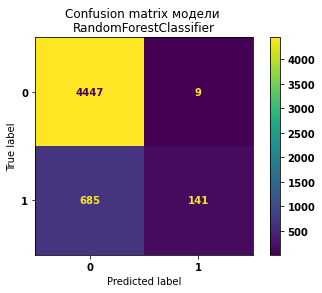

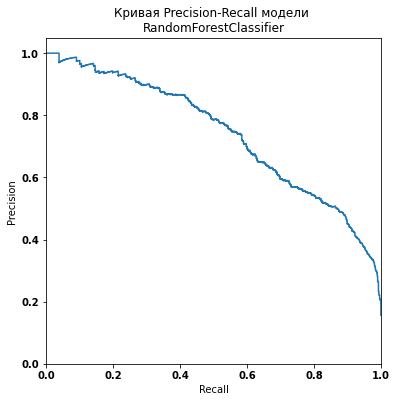

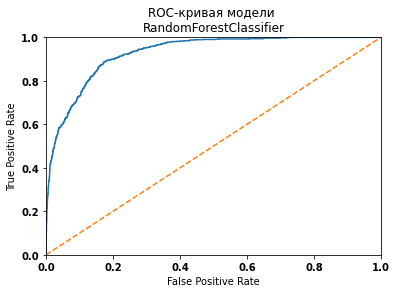

In [119]:
result_visualisation(gs_rf, X_train, y_train, 'RandomForestClassifier')

Недостаточно высокий уровень ROC-AUC. Немало ложноотрицательных результатов (т.е. тех самых, которые не очень хорошо для нажего бизнеса - модель предсказывает, что человек не уйдет, всякие плюшки ему не даются, а он уходит, в итоге отток клиентуры)

#### Логистическая регрессия

In [120]:
model_lr = LogisticRegression(random_state=RANDOM_STATE)
pipline_lr = make_pipeline(col_transformer_lr, model_lr)

In [121]:
param_grid_lr = {
    'logisticregression__solver': ['lbfgs', 'newton-c', 'newton-cholesky','sag', 'saga'],
    'logisticregression__penalty': ['l2', None],
    'logisticregression__C': [0.1, 0.25, 0.5, 1],
}

In [122]:
gs_lr = RandomizedSearchCV(
    pipline_lr,
    param_distributions=param_grid_lr,
    scoring = 'roc_auc',
    n_jobs=-1,
    cv = 5,
    random_state=RANDOM_STATE
)
gs_lr.fit(X_train_rf, y_train)

RandomizedSearchCV(cv=5,
                   estimator=Pipeline(steps=[('columntransformer',
                                              ColumnTransformer(remainder='passthrough',
                                                                transformers=[('onehotencoder',
                                                                               OneHotEncoder(drop='first'),
                                                                               ['gender',
                                                                                'SeniorCitizen',
                                                                                'Partner',
                                                                                'Dependents',
                                                                                'Type',
                                                                                'PaperlessBilling',
                                                                                'PaymentMethod',
                                                                                'expences_rank',
                                                                                'MultipleLines',
                                                                                'InternetService',
                                                                                'OnlineSecurity',
                                                                                'OnlineBackup',
                                                                                'Devi...
                                                                              ('standardscaler',
                                                                               StandardScaler(),
                                                                               ['days',
                                                                                'TotalCharges'])])),
                                             ('logisticregression',
                                              LogisticRegression(random_state=13112023))]),
                   n_jobs=-1,
                   param_distributions={'logisticregression__C': [0.1, 0.25,
                                                                  0.5, 1],
                                        'logisticregression__penalty': ['l2',
                                                                        None],
                                        'logisticregression__solver': ['lbfgs',
                                                                       'newton-c',
                                                                       'newton-cholesky',
                                                                       'sag',
                                                                       'saga']},
                   random_state=13112023, scoring='roc_auc')

In [123]:
gs_lr_best_score = gs_lr.best_score_
gs_lr_best_params = gs_lr.best_params_
print(f'best_score: {gs_lr_best_score}')
print(f'best_params: {gs_lr_best_params}')

best_score: 0.7871725338265558
best_params: {'logisticregression__solver': 'saga', 'logisticregression__penalty': None, 'logisticregression__C': 1}


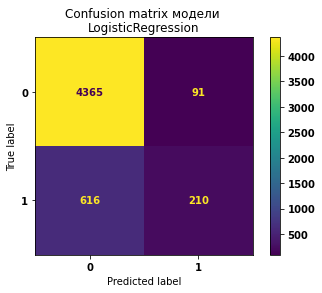

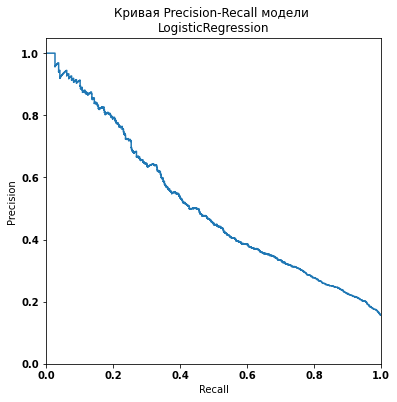

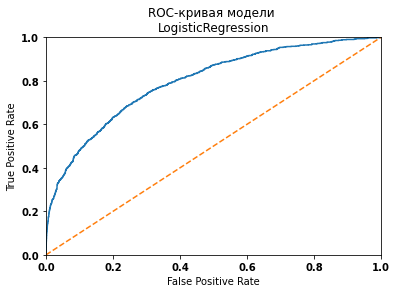

In [124]:
result_visualisation(gs_lr, X_train, y_train, 'LogisticRegression')

Модель работает ещё хуже. Имеется большое количество ложноотрицательных результатов

#### CatBoostClassifier

In [125]:
model_cb = CatBoostClassifier(random_state=RANDOM_STATE)
pipline_cb = make_pipeline(col_transformer_rf, model_cb)

In [126]:
param_grid_cb = {
    'catboostclassifier__n_estimators': range(10, 251, 10),
    'catboostclassifier__max_depth': range(2, 15),
}

In [127]:
gs_cb = RandomizedSearchCV(
    pipline_cb,
    param_distributions=param_grid_cb,
    scoring = 'roc_auc',
    n_jobs=-1,
    cv = 5,
    random_state=RANDOM_STATE
)
gs_cb.fit(X_train_rf, y_train)

Learning rate set to 0.07336
0:	learn: 0.6332840	total: 49.3ms	remaining: 11.3s
1:	learn: 0.5865778	total: 51.6ms	remaining: 5.88s
2:	learn: 0.5444987	total: 53.6ms	remaining: 4.05s
3:	learn: 0.5103125	total: 55.7ms	remaining: 3.15s
4:	learn: 0.4878953	total: 57.6ms	remaining: 2.59s
5:	learn: 0.4640616	total: 59.9ms	remaining: 2.23s
6:	learn: 0.4524629	total: 60.7ms	remaining: 1.93s
7:	learn: 0.4366624	total: 62.9ms	remaining: 1.74s
8:	learn: 0.4211299	total: 64.9ms	remaining: 1.59s
9:	learn: 0.4139394	total: 65.9ms	remaining: 1.45s
10:	learn: 0.4032978	total: 68ms	remaining: 1.35s
11:	learn: 0.3923839	total: 70.2ms	remaining: 1.28s
12:	learn: 0.3821489	total: 72.5ms	remaining: 1.21s
13:	learn: 0.3760995	total: 74.7ms	remaining: 1.15s
14:	learn: 0.3679536	total: 77ms	remaining: 1.1s
15:	learn: 0.3651072	total: 78.1ms	remaining: 1.04s
16:	learn: 0.3606491	total: 80.4ms	remaining: 1.01s
17:	learn: 0.3570462	total: 82.5ms	remaining: 972ms
18:	learn: 0.3521134	total: 84.7ms	remaining: 941m

RandomizedSearchCV(cv=5,
                   estimator=Pipeline(steps=[('columntransformer',
                                              ColumnTransformer(remainder='passthrough',
                                                                transformers=[('onehotencoder',
                                                                               OneHotEncoder(drop='first'),
                                                                               ['gender',
                                                                                'SeniorCitizen',
                                                                                'Partner',
                                                                                'Dependents',
                                                                                'Type',
                                                                                'PaperlessBilling',
                                                                                'PaymentMethod',
                                                                                'expences_rank',
                                                                                'MultipleLines',
                                                                                'InternetService',
                                                                                'OnlineSecurity',
                                                                                'OnlineBackup',
                                                                                'Devi...
                                                                               OrdinalEncoder(handle_unknown='use_encoded_value',
                                                                                              unknown_value=-1),
                                                                               ['PaymentMethod',
                                                                                'expences_rank',
                                                                                'InternetService'])])),
                                             ('catboostclassifier',
                                              <catboost.core.CatBoostClassifier object at 0x7f264c4cf7f0>)]),
                   n_jobs=-1,
                   param_distributions={'catboostclassifier__max_depth': range(2, 15),
                                        'catboostclassifier__n_estimators': range(10, 251, 10)},
                   random_state=13112023, scoring='roc_auc')

In [128]:
gs_cb_best_score = gs_cb.best_score_
gs_cb_best_params = gs_cb.best_params_
print(f'best_score: {gs_cb_best_score}')
print(f'best_params: {gs_cb_best_params}')

best_score: 0.8800272166339779
best_params: {'catboostclassifier__n_estimators': 240, 'catboostclassifier__max_depth': 7}


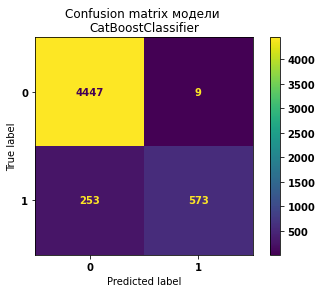

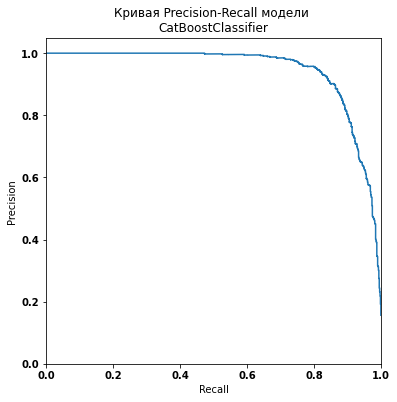

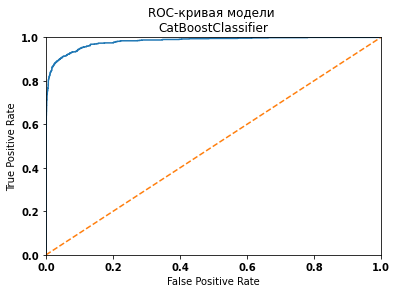

In [129]:
result_visualisation(gs_cb, X_train, y_train, 'CatBoostClassifier')

Высокий ROC-AUC, модель хорошая. Уже не очень много ложно отрицательных результатов, т.е. мы более точно понимаем, что человек может уйти, тем самым можем предложить ему бонусы ,чтобы не уходил.

#### LightGBM

In [130]:
model_lgb = lgb.LGBMClassifier(random_state=RANDOM_STATE)
pipline_lgb = make_pipeline(col_transformer_rf, model_lgb)

In [131]:
param_grid_lgb = {
    'lgbmclassifier__n_estimators': range(50, 251, 10),
    'lgbmclassifier__max_depth': range(2, 15),
}

In [132]:
gs_lgb = RandomizedSearchCV(
    pipline_lgb,
    param_distributions=param_grid_lgb,
    scoring = 'roc_auc',
    n_jobs=-1,
    cv = 5,
    random_state=RANDOM_STATE
)
gs_lgb.fit(X_train_rf, y_train)

RandomizedSearchCV(cv=5,
                   estimator=Pipeline(steps=[('columntransformer',
                                              ColumnTransformer(remainder='passthrough',
                                                                transformers=[('onehotencoder',
                                                                               OneHotEncoder(drop='first'),
                                                                               ['gender',
                                                                                'SeniorCitizen',
                                                                                'Partner',
                                                                                'Dependents',
                                                                                'Type',
                                                                                'PaperlessBilling',
                                                                                'PaymentMethod',
                                                                                'expences_rank',
                                                                                'MultipleLines',
                                                                                'InternetService',
                                                                                'OnlineSecurity',
                                                                                'OnlineBackup',
                                                                                'Devi...
                                                                              ('ordinalencoder',
                                                                               OrdinalEncoder(handle_unknown='use_encoded_value',
                                                                                              unknown_value=-1),
                                                                               ['PaymentMethod',
                                                                                'expences_rank',
                                                                                'InternetService'])])),
                                             ('lgbmclassifier',
                                              LGBMClassifier(random_state=13112023))]),
                   n_jobs=-1,
                   param_distributions={'lgbmclassifier__max_depth': range(2, 15),
                                        'lgbmclassifier__n_estimators': range(50, 251, 10)},
                   random_state=13112023, scoring='roc_auc')

In [133]:
gs_lgb_best_score = gs_lgb.best_score_
gs_lgb_best_params = gs_lgb.best_params_
print(f'best_score: {gs_lgb_best_score}')
print(f'best_params: {gs_lgb_best_params}')  

best_score: 0.8918435564401681
best_params: {'lgbmclassifier__n_estimators': 230, 'lgbmclassifier__max_depth': 4}


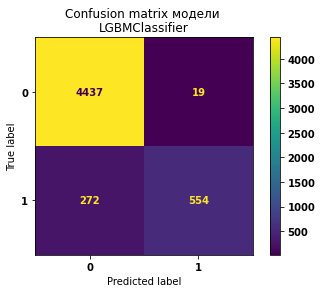

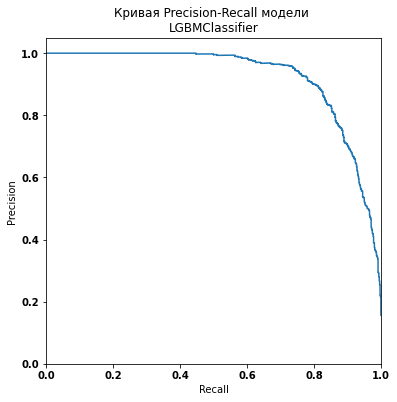

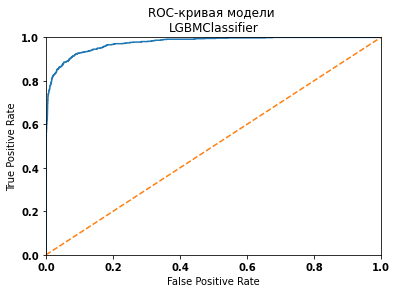

In [134]:
result_visualisation(gs_lgb, X_train, y_train, 'LGBMClassifier')

Тоже высокий ROC-AUC, модель ещё лучше. Ситуация примерно похожа на модель CatBoostClassifier

### Промежуточный итог 5
Были обучены 4 разные модели, посчитана метрика ROC-AUC для каждой из них (обучаемые модели: `RandomForestClassifier`,`LogisticRegression`,`CatBoostClassifier`,`LGBMClassifier`)

## Выбор лучшей модели

In [135]:
pd.DataFrame(data = [gs_rf_best_score,gs_lr_best_score,gs_cb_best_score,gs_lgb_best_score], 
columns = ['ROC-AUC'], index = ['RandomForestClassifier','LogisticRegression','CatBoostClassifier','LGBMClassifier'])


,ROC-AUC
RandomForestClassifier,0.827751
LogisticRegression,0.787173
CatBoostClassifier,0.880027
LGBMClassifier,0.891844


Видно, что лучшая по ROC_AUC модель - LGBMClassifier, проверим на тестовой выборке

In [136]:
gs_lgb_best_accuracy = accuracy_score(gs_lgb.best_estimator_.predict(X_test), y_test)
gs_lgb_best_roc_auc = roc_auc_score(gs_lgb.best_estimator_.predict(X_test), y_test)
print(f'best_accuracy: {gs_lgb_best_accuracy}')
print(f'best_roc_auc: {gs_lgb_best_roc_auc}') 

best_accuracy: 0.9068710959681999
best_roc_auc: 0.878922748447205


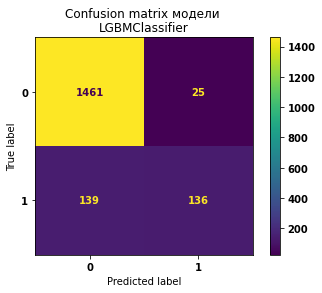

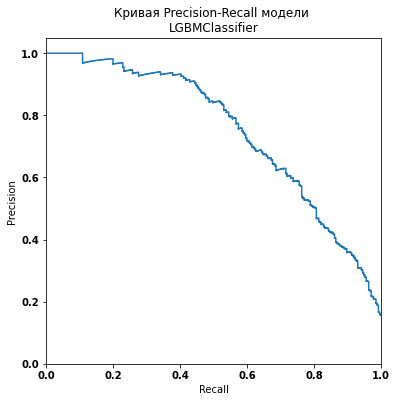

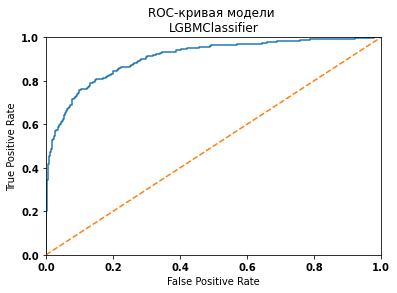

In [137]:
result_visualisation(gs_lgb, X_test, y_test, 'LGBMClassifier')

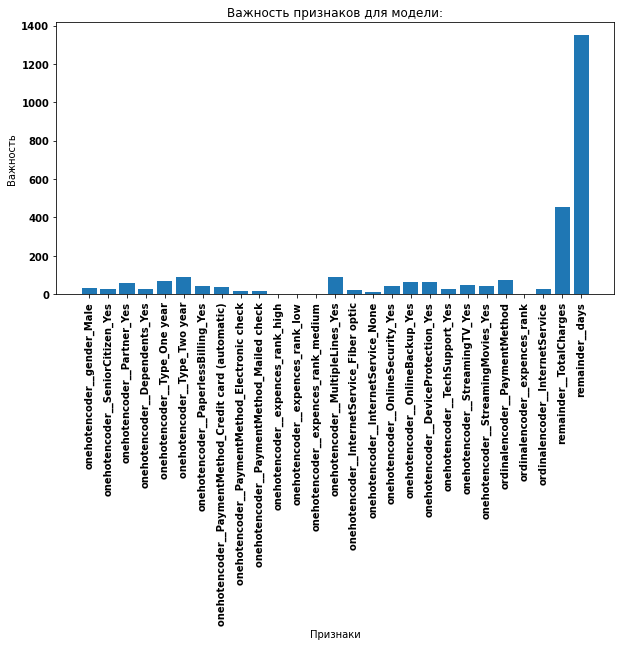

In [138]:
features_importance(gs_lgb, 'LGBMClassifier')

Как можно отметить, самыми важными признаками для нашей модели являются общие траты (TotalCharges) и количество дней пользования сервисом (days), поэтому на эти признаки надо будет обращать особое внимание при подготовке данных для модели

### Промежуточный итог 6
Была выбрана лучшая модель - `LGBMClassifier`, чья метрика ROC-AUC на тестовой выборке составляет 92.8%.

На **`тестовой выборке`** её **`ROC-AUC составляет 90.68%`**, **`точность - 87.89 %`**.

Это очень хорошие показатели (они не говорят в пользу переобучения, т.к. 1) это тестовая выборка, 2) модель не настолько сложна, чтобы выучить и трейн, и тест 3) значения не овер-высокие (97, 98, 99..)
Очень мало ложноположительных результатов, т.е. мы зря не предлагаем клиенту бонусы - он не уходит от нас, немного ложноотрицательных результатов, т.е. мы предсказали, что клиент не уйдет, не пытаемся уго удержать, а он уходит.
Остальные варианты (предсказали, что не уйдет и не ушел, или, предсказали, что уйдет и ушел, в большом количестве правильно предсказаны моделью). 

Больше всего модель брала в расчет количество дней пользования и общую сумму трат за все время, следовательно на эти признаки надо будет обращать особое внимание при подготовке данных для модели

## Общий вывод и рекомендации заказчику

### Промежуточный итог 1

Были загружены все датасеты и произведен их беглый осмотр. Получены следующие результаты.

В датафейме, содержащем информацию о договоре, 8 столбцов, 7043 строки.
Столбцы следующие:
- `customerID` — идентификатор абонента;
- `BeginDate` — дата начала действия договора;
- **`EndDate` — дата окончания действия договора;** 
    - уже в первых строчках видно, что есть договоры без даты окончания действия, следовательно, это клиенты, которые не перестали пользоваться услугами связи оператора
- `Type` — тип оплаты: раз в год-два или ежемесячно;
- `PaperlessBilling` — электронный расчётный лист;
- `PaymentMethod` — тип платежа;
- `MonthlyCharges` — расходы за месяц;
- `TotalCharges` — общие расходы абонента.

В датафейме, содержащем информацию об интернет-услугах , 8 столбцов, 5517 строк.
Столбцы следующие:
- `customerID` — идентификатор пользователя;
- `InternetService` — тип подключения;
- `OnlineSecurity` — блокировка опасных сайтов;
- `OnlineBackup` — облачное хранилище файлов для резервного копирования данных;
- `DeviceProtection` — антивирус;
- `TechSupport` — выделенная линия технической поддержки;
- `StreamingTV` — стриминговое телевидение;
- `StreamingMovies` — каталог фильмов.

В датафейме, содержащем информацию о персональных данных клиента , 5 столбцов, 7043 строки.
Столбцы следующие:
- `customerID` — идентификатор пользователя;
- `gender` — пол;
- `SeniorCitizen` — является ли абонент пенсионером;
- `Partner` — есть ли у абонента супруг или супруга;
- `Dependents` — есть ли у абонента дети.

В датафейме, содержащем информацию информация об услугах телефонии, 2 столбца, 6361 строка.
Столбцы следующие:
- `customerID` — идентификатор пользователя;
- `MultipleLines` — подключение телефона к нескольким линиям одновременно.

### Промежуточный итог 2
Был проведен исследовательский анализ и предобработка исходных датасетов (до объединения) с выводом соответсвующих результатов и графиков.

#### Датафрейм информации о договоре
Для начала отмечу, что дубликатов в данных нет, пропусков тоже. Налицо проблема типов данных, необходимо её исправить.

Видно, что все столбцы, кроме `MonthlyCharges` - типа `object`, хотя `BeginDate` и `TotalCharges` точно относятся не к этому типу.

Заменил типы столбцов: `MonthlyCharges` - на DateTime, а `TotalCharges` - к типу float.

После этого появились пропуски. 
Видно, что это клиенты, не прекратившие пользоваться услугами, а также у них есть помесячная оплата + типы оплаты - раз в год/два. Видно, что все клиенты только зарегистрировались в системе (данные актуальны на момент `2020-02-01`), поэтому в принципе их траты можно принять равными нулю, так как, я проверил, есть клиенты с типом оплаты раз в год/два, которые зарегистрировались в январе 2020 года и их траты равны тратам одного месяца, в то время как все, кто зарегистрировался в феврале 2020 года, являются пропусками.

Распределение по годам начала использования сервиса: видно два пика начала пользования сервисом: в 2014 и в 2020 годах.

Большинство клиентов пользуются помесячной оплатой, меньше всего - оплатой раз в год, хотя их количество примерно равно количеству оплачивающих раз в два года.

Примерно 60% клиентов пользуются электронным расчетным листом, остальные - нет

Помесячная оплата имеет где-то три пика, два острых, один сглаженный.

На распределении общих трат видно касту людей, у которых нулевые траты (это наши заполненные пропуски, так как человеки только зарегистрировались), а также пик в районе 25 долларов, и далее почти постепенное убывание по мере увеличение общих расходов до 9000. 

Был введен новый признак с делением по уровням расходов на 4 категории.

#### Датафрейм информации об интернет-услугах

Видно, что в датафрейме с данными об интернет-услугах нет дубликатов, пропусков.
В колонке с ID пользователей нет дубликатов (count = unique).
Во всех остальных колонках по 2 значения, по сути, булевые данные, однако прям чисто буль везде, кроме `InternetService`, так как там наименования типов подключения.

В принципе, можно преобразовать типы столбцов, где Yes/No к типу boolean, но в этом, наверное, нет особой необходимости. Приведу к формату нолей и единиц

Больше всего подписок на: облачное хранилище файлов для резервного копирования данных, стриминговое телевидение и каталог фильмов.

#### Датасет с информацией о персональных данных клиента

Дубликатов нет, пропусков нет.
Большинство клиентов (83.79%) не являются пенсионерами.
Есть/нет супруг/супруга примерно 50/50 (чуть-чуть больше холостых/вдовствующих).
Примерно 30% клиентов имеют детей.
Полов практические одинаковое количество.

Есть два столбца: наличие/отсутствие супруга(-и) и наличие/отсутствие детей.
Можно добавить столбец `is_full_family`, в котором будут значения:
- 2, если есть супруг/супруга и дети (полная семья)
- 1, если есть супруг/супруга, но нет детей (семья без детей)
- 0, все остальные случаи (неполная семья)

Видно, что больше всего клиентов из неполной семьи. Клиентов из полной семьи или семьи без детей примерно поровну между собой.

#### Датасет с информацией об услугах телефонии

Пропусков нет, дубликатов тоже
Примерно 53% пользователей подключены к услуге по подключению телефона к нескольким линиям одновременно, 47% не подключены

### Промежуточный итог 3
Было произведено объединение всех фреймов данных, проверена полноценность этого объединения. Ключом служил customerID.

### Промежуточный итог 4
Был произведен исследовательский анализ и предобработка объединенного датафрейма. Получены следующие результаты:
- добавили целевой признак по дате окончания договора - если её нет, значит, клиент остался, в то время как её наличие говорит о том, что клиент разорвал договор
- в районе 15.63% клиентов разрывают договор, 85.37% - нет
- сразу после добавления таргета, избавился от столбцов с датами, после чего приступил к анализу, также я избавился от CustomerID
- Дубликатов нет, но появились пропуски от того, что сливаемые датафреймы имели разный размер, заполним же пропуски
- Так как в объединенном датафрейме категориальные данные закодированы как 1 и 0, кроме `InternetService`, просто использовал fillna(0), так как отсутствие данные равносильно отсутствию подписки на интернет-сервисы или на подключение телефона к нескольким линиям одновременно. А пропуски в `InternetService` заполнил `None`.
- Рассмотрев выборки клиентов, разовравших контракт и тех, кто не разорвал, видно, что среди разовравших договор (по сравнению с неразорвавшими) выше процент пользователей услугами (услуга подключения телефона к нескольким линиям одновременно, услуга блокировки опасных сайтов, услуга облачного хранилища файлов для резервного копирования данных, услуга антивируса, услуга выделенной линии технической поддержки, услуга стримингового телевидения, услуга каталога фильмов) или тех, кто имел семью/детей, являлся пенсионером 
- У клиентов, у которых либо есть подписки, либо они пенсионеры, либо имеют супруга/супругу или детей между собой практически не имеют разницы в оттоке (аналогично для тех, у кого нет подписок или отсутствуют супруг(-а), дети, не являются пенсионерами)
    - пенсионеры оттекают чаще, чем не пенсионеры на 6%
    - люди с супругом(-ой) оттекают чаще, чем без на 11%
    - люди с детьми оттекают чаще, чем без на 2.5%
    - люди с услугой подключения телефона к нескольким линиям одновременно оттекают чаще на 12.5%
    - люди с блокировкой опасных сайтов оттекают чаще на 7%
    - люди с облачным хранилищем файлов для резервного копирования данных оттекают чаще на 11.5%
    - люди с антивирусом оттекают чаще на 11%
    - люди с выделенной линией технической поддержки оттекают чаще на 5.5%
    - люди со стриминговым телевидением оттекают чаще на 9.5%
    - люди с каталогом фильмов оттекают чаще на 11%
- также были рассмотрены другие категориальные признаки:
    - практически нет разницы в соотношении полов между дейсвтующими и оттекшими клиентами
    - по способу оплаты видно, что чаще оттекают клиенты с оплатой раз в год или два, тогда как клиенты с помесячной оплатой оттекают меньше
    - чуть чаще оттекают люди с электронным расчетным листом
    - реже всего по типу платежа оттекают клиенты с чеком по почте, в то время как клиенты с автоматическим банковским трансфером или электронным чеком оттекают чаще 
    - по уровню расходов видно, что очень мало оттекает клиентов с низкими тратами (до 500 долларов), в то время с высокими тратами (от 1500 до 3000 долларов) оттекают чаще всего, их отток выше аж почти на 20%
    - клиенты с оптоволовном оттекают чаще на 12%
- была проверка на корреляции между признаками:
    - Видно, что гиперскоррелированным с несколькими признаками является признак `MonthlyCharges`, а также пары гиперскоррелированных признаков `TotalCharges`-`expences_rank` и `Partner`-`is_full_family`. Я избавлюсь от `MonthlyCharges`, а  `expences_rank` и `is_full_family` - введённые мной признаки, пока попробую убрать `is_full_family`.

### Промежуточный итог 5
Были обучены 4 разные модели, посчитана метрика ROC-AUC для каждой из них (обучаемые модели: `RandomForestClassifier`,`LogisticRegression`,`CatBoostClassifier`,`LGBMClassifier`)

### Промежуточный итог 6
Была выбрана лучшая модель - `LGBMClassifier`, чья метрика ROC-AUC на тестовой выборке составляет 92.8%.

На **`тестовой выборке`** её **`ROC-AUC составляет 90.68%`**, **`точность - 87.89 %`**. Это очень хорошие показатели (они не говорят в пользу переобучения, т.к. 1) это тестовая выборка, 2) модель не настолько сложна, чтобы выучить и трейн, и тест 3) значения не овер-высокие (97, 98, 99..)
Очень мало ложноположительных результатов, т.е. мы зря не предлагаем клиенту бонусы - он не уходит от нас, немного ложноотрицательных результатов, т.е. мы предсказали, что клиент не уйдет, не пытаемся уго удержать, а он уходит.
Остальные варианты (предсказали, что не уйдет и не ушел, или, предсказали, что уйдет и ушел, в большом количестве правильно предсказаны моделью). 

Больше всего модель брала в расчет количество дней пользования и общую сумму трат за все время, следовательно на эти признаки надо будет обращать особое внимание при подготовке данных для модели

### ИТОГ
Была получена хорошая модель для предсказания ухода клиента. Её точность составила 90%, что является очень хорошим результатом. Интерпретация метрик качества см. в пункте `7.6 Промежуточный итог 6`. Самое важное, что стоит контролировать - чтобы было подсчитано общее количество дней пользования сервисом и общая сумма трат. Все это необходимо как можно точнее для данной модели.